<img src="images\GRU_formulas.jpg" width=800>
<img src="images\GRU_shapes.jpg" width=200>
<img src="images\GRU_derivatives.jpg" width=800>

In [1]:
import random, math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=16,5


def load_data_txt(filename, dimensions, max_len=None):
    f = open(filename, "r")
    data = []
    print("loading data")
    for line in f:
        for c in line:
            if ord(c)-ord('A') > 0 and ord(c)-ord('A') < dimensions:
                new_data = []
                for i in range(0, dimensions):
                    new_data.append([0])
                    
                new_data[ord(c)-ord('A')] = [1]
                data.append(new_data)
                if max_len != None:
                    if len(data) >= max_len:
                        print("all loaded")    
                        return data
                    
    print("all loaded")    
    return data
            
def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    p = np.exp(x - np.max(x))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z)
    else:
        if act=="sigmoid":
            return activated_value * (1 - activated_value)
        elif act == "swish":
            return activated_value + sigmoid(z) * (1 - activated_value)
        elif act == "relu":  
            x = activated_value
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return activated_value

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, last_activation=None):
        new_layer = Layer(input_size, output_size, last_activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data):
        self.layers[0].forward_pass(input_data)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].h[-1]        # Takes in the output of the previous layer. h[-1] is the hidden state of the last timestep of the layer
            self.layers[i].forward_pass(prev_layer_out)
            
        return self.layers[-1].h[-1]
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps):
        gradient, loss = self.layers[-1].der_MSE(target)
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].h
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps)
        return loss
    
    def predict(self, input_data):
        next_letter = []
        out_letter = []
        for i in range(0, len(input_data)):
            next_letter = self.forward_pass(input_data[i])
            
        out_letter = next_letter
        print_output = ""
        for i in range(500, 700):
            maximum = 0;
            max_index = 0;
            for k in range(0, 3):
                if next_letter[k][0] > maximum:
                    maximum = next_letter[k][0]
                    max_index = k
            out_letter = np.empty(next_letter.shape)
            out_letter.fill(0)
            out_letter[max_index,0] = 1
            print_output += chr(ord('A')+max_index)
            next_letter = self.forward_pass(out_letter)
        print(print_output)
    
class Layer():
    
    def __init__(self, input_size, output_size, last_activation=None):
        self.input_size = input_size # N
        self.output_size = output_size # M
        self.last_activation = last_activation
        
        self.Wz = self.weights_init(output_size, input_size) # NxM
        self.Wr = self.weights_init(output_size, input_size) # NxM
        self.Wh = self.weights_init(output_size, input_size) # NxM
        
        self.Uz = self.weights_init(output_size, output_size) # NxN
        self.Ur = self.weights_init(output_size, output_size) # NxN
        self.Uh = self.weights_init(output_size, output_size) # NxN
        
        self.bz = self.weights_init(output_size, 1, bias=True) # Nx1
        self.br = self.weights_init(output_size, 1, bias=True) # Nx1
        self.bh = self.weights_init(output_size, 1, bias=True) # Nx1
        
        # T = time steps, starts with 0
        
        self.z       = np.empty((0,output_size,1)) # TxNx1, z(t) = Nx1
        self.r       = np.empty((0,output_size,1)) # TxNx1, r(t) = Nx1
        self.h_tilde = np.empty((0,output_size,1)) # TxNx1, h_tilde(t) = Nx1
        self.h       = np.empty((0,output_size,1)) # TxNx1, h(t) = Nx1
        self.inputs  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
    def weights_init(self, rows, cols, bias=False):
        variance = math.sqrt(1/self.input_size)
        if bias:
            return np.random.uniform(0,0.01,(rows, cols))
        return np.random.uniform(-variance,variance,(rows, cols))
    
    
    def forward_pass(self, input_data):
        
        self.inputs = np.append(self.inputs, [input_data])
        prev_h = []
        if len(self.h) > 0:
            prev_h = self.h[-1]
        else:
            prev_h = np.empty((self.h.shape[1], self.h.shape[2]))
            prev_h.fill(0)
        
        new_z = self.Wz @ input_data + self.Uz @ prev_h + self.bz
        new_z = activation_function(new_z, "sigmoid")
        self.z = np.append(self.z, [new_z], axis=0)
        
        new_r = self.Wr @ input_data + self.Ur @ prev_h + self.br
        new_r = activation_function(new_r, "sigmoid")
        self.r = np.append(self.r, [new_r], axis=0)
        
        new_h_tilde = self.Wh @ input_data + self.r[-1] * (self.Uh @ prev_h) + self.bh
        new_h_tilde = activation_function(new_h_tilde, "tanh")
        self.h_tilde = np.append(self.h_tilde, [new_h_tilde], axis=0)
        
        new_h = self.z[-1] * self.h_tilde[-1] + (1 - self.z[-1]) * prev_h
        self.h = np.append(self.h, [new_h], axis=0)
        
        
        if len(self.z) > 30:
            self.z = np.delete(self.z, 0, 0)
        if len(self.r) > 30:
            self.r = np.delete(self.r, 0, 0)
        if len(self.h_tilde) > 30:
            self.h_tilde = np.delete(self.h_tilde, 0, 0)
        if len(self.h) > 30:
            self.h = np.delete(self.h, 0, 0)
            
            
        
    def clear_memory(self):
        self.z       = np.empty((0,self.output_size,1))
        self.r       = np.empty((0,self.output_size,1))
        self.h_tilde = np.empty((0,self.output_size,1))
        self.h       = np.empty((0,self.output_size,1))
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
        
    def der_MSE(self, target):
        if self.last_activation != None:
            return 2*(self.h[-1] - target) * activation_function(self.h[-1], self.last_activation, derivative=True, activated_value=self.h[-1]), np.power(target - self.h[-1], 2)
        return 2*(self.h[-1] - target), np.power(target - self.h[-1], 2)
     
    
    def descent(self, gradient, input_data, learning_rate, max_steps):
        input_matrix = np.array(input_data)
        first_index = max(len(self.h) - max_steps, 0)
        
        step = 0
        #inputs_reshaped = np.sum(self.inputs[first_index], axis=0, keepdims=True)
        #inputs_reshaped = np.tile(inputs_reshaped, (self.output_size, 1))
        inputs_reshaped = np.array(input_data[first_index])
        z_act = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        r_act = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        htilde_act = activation_function(self.h_tilde[first_index], "tanh", derivative=True, activated_value=self.h_tilde[first_index])
        
        dr_Wr = np.tile(r_act, (1, self.input_size))
        dr_Wr *= (np.tile(inputs_reshaped.T, (self.output_size, 1)))
        dz_Wr = np.empty(dr_Wr.shape)
        dz_Wr.fill(0)
        dhtilde_Wr = np.empty(dr_Wr.shape)
        dhtilde_Wr.fill(0)
        dh_Wr = np.empty(dr_Wr.shape)
        dh_Wr.fill(0)
        
        #dr_Wz = dr_Wr
        #dz_Wz = dz_Wr
        #dhtilde_Wz = dhtilde_Wr
        #dh_Wz = dz_Wz * (-self.h_tilde[first_index]) + dhtilde_Wz * (1 - self.z[first_index])
        
        #dz_Uz = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        #dr_Uz = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        #dhtilde_Uz = activation_function(self.h_tilde[first_index], "tanh", derivative=True, activated_value=self.h_tilde[first_index])
        #dh_Uz = dz_Uz * (-self.h_tilde[first_index]) + dhtilde_Uz * (1 - self.z[first_index])
        #
        #dz_bz = dz_Uz
        #dr_bz = dr_Uz
        #dhtilde_bz = dhtilde_Uz
        #dh_bz = dz_bz * (-self.h_tilde[first_index]) + dhtilde_bz * (1 - self.z[first_index])
        #
        dr_x = np.tile(r_act, (1, self.input_size))
        dr_x *= self.Wr
        dr_x = np.sum(dr_x, axis=0, keepdims=True).T
        
        dz_x = np.tile(z_act, (1, self.input_size))
        dz_x *= self.Wz
        dz_x = np.sum(dz_x, axis=0, keepdims=True).T
        #
        #dz_Wh = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        #dz_Wh = self.Uz @ dz_Wh
        #dh_Wh = -(dz_Wh)*(self.h_tilde[first_index])
        #
        #dr_Wh = 0
    #
        #
        #
        dhtilde_x = np.tile(htilde_act, (1, self.input_size))
        prev_h = np.empty((self.output_size, 1)) if len(self.h) < 2 else self.h[-2]
        Uhht1 = self.Uh @ prev_h
        Uhht1 = np.tile(np.sum(Uhht1, axis=0, keepdims=True), (self.input_size, 1))
        dhtilde_x *= (self.Wh + np.tile((dr_x * Uhht1).T, (self.output_size, 1)))
        dhtilde_x = np.sum(dhtilde_x, axis=0, keepdims=True).T # from NxM to Mx1
        
        Wh_reshaped = np.sum(self.Wh, axis=0, keepdims=True).T # from NxM to Mx1
        
        Uhprev_h = np.sum(np.tile(self.Uh @ prev_h, (1, self.input_size)), axis=0, keepdims=True).T
        dhtilde_x *= (Wh_reshaped + dr_x * Uhprev_h)
        
        h_subtract = np.tile(prev_h - self.h_tilde[-1], (1, self.input_size))
        h_subtract = np.sum(h_subtract, axis=0, keepdims=True).T
        one_minus = np.tile((1 - self.z[-1]), (1, self.input_size))
        one_minus = np.sum(one_minus, axis=0, keepdims=True).T
        dh_x = dz_x * h_subtract + dhtilde_x * one_minus
        
        step = 1
        
        
        
        while step + first_index < len(self.h): 
            
            inputs_reshaped = np.array(input_data[first_index + step])
            #print("first_index: " + str(first_index))
        
            """Wr gradient steps"""
            dr_Wr = np.tile(r_act, (1, self.input_size))
            xt = np.tile(inputs_reshaped.T, (self.output_size, 1))
            ht1wu = dh_Wr * np.tile(np.sum(self.Uz, axis=0, keepdims=True).T, (1, self.input_size))
            #print(str(xt.shape) + str(ht1wu.shape))
            dz_Wr = np.tile(z_act, (1, self.input_size))
            dz_Wr *= ht1wu
            ht1wu = dh_Wr * np.tile(np.sum(self.Ur, axis=0, keepdims=True).T, (1, self.input_size))
            dr_Wr *= (xt + ht1wu)
            dhtilde_Wr = np.tile(htilde_act, (1, self.input_size))
            Uhht1 = self.Uh @ self.h[first_index+step-1]
            #print(str(Uhht1.shape))
            Uhht1 = np.tile(Uhht1, (1, self.input_size))
            Uhrt = self.Uh * np.tile(self.r[first_index+step], (1, self.output_size))
            Uhrt = np.tile(np.sum(Uhrt, axis=0, keepdims=True).T, (1, self.input_size))
            #print(str(dr_Wr.shape) + str(Uhht1.shape) + str(dh_Wr.shape) + str(Uhrt.shape))
            dhtilde_Wr *= (dr_Wr * Uhht1 + dh_Wr * Uhrt)
            h_subtract = np.tile(self.h[first_index+step-1] - self.h_tilde[first_index+step], (1, self.input_size))
            zt = np.tile(self.z[first_index+step], (1, self.input_size))
            dh_Wr = dz_Wr * h_subtract + dh_Wr * zt + dhtilde_Wr * (1 - zt)
            
            
            #"""Wz gradient steps"""
            #
            #dr_Wz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Wz *= (inputs_reshaped + self.Ur @ dh_Wz)
            #
            #dz_Wz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Wz *= (inputs_reshaped + self.Uz @ dh_Wz)
            #dhtilde_Wz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Wz *= (inputs_reshaped + dr_Wz * (self.Uh @ self.h[first_index+step-1]) + dh_Wz * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Wz = dz_Wz * (self.h[first_index+step-1] - self.h_tilde[first_index+step]) \
            #+ dh_Wz * self.z[first_index+step] + dhtilde_Wz * (1 - self.z[first_index+step])
            #
            #"""Uz gradient steps"""
            #
            #dz_Uz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Uz *= (self.h[first_index-1+step] + self.Uz @ dh_Uz)
            #
            #dr_Uz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Uz *= (self.h[first_index-1+step] + self.Ur @ dh_Uz)
            #
            #dhtilde_Uz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Uz *= ((self.Uh @ self.h[first_index-1+step]) * dr_Uz + self.r[first_index+step] * self.h[first_index-1+step] + dh_Uz * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Uz = dz_Uz * (self.h[first_index-1+step]-self.h_tilde[first_index+step]) + dh_Uz * self.z[first_index+step] + dhtilde_Uz * (1 - self.z[first_index+step])
            #
            #
            #"""bz gradient steps"""
            #
            #dz_bz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_bz *= (self.Uz @ dh_bz + 1)
            #
            #dr_bz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_bz *= (self.Ur @ dh_bz + 1)
            #
            #dhtilde_bz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_bz *= (dr_bz * (self.Uh @ self.h[first_index+step-1]) + dh_bz * (self.Uh @ self.r[first_index+step-1]))
            #
            #dh_bz = dz_bz * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + dh_bz * self.z[first_index+step] + dhtilde_bz * (1 - self.z[first_index+step])
            #
            #
            #
            #"""Wh gradient steps"""
            #
            #dz_Wh = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Wh *= (self.Uz @ dh_Wh)
            #dhtilde_Wh = (1-self.h_tilde[first_index] @ self.h_tilde[first_index]) * (inputs_reshaped + (self.Uh @ (self.h[first_index+step-1])) * dr_Wh + (self.Uh @ dh_Wh ) * self.r[first_index+step])
            #                                                                            #dh_Wh is dht-1_Wh 
            #dr_Wh = activation_function(self.r[first_index], "sigmoid",derivative=True, activated_value = self.r[first_index])
            #dr_Wh *= self.Ur @ dh_Wh
            #dh_Wh = dz_Wh * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + (1-self.z[first_index+step])*dhtilde_Wh + dh_Wh * self.z[first_index+step]
                                                                                        #dh_Wh is now dht_Wh
                
            step+=1
                
        #print(str(self.input_size))
        
        dh_Wr *= np.tile(gradient, (1, self.input_size))
        
        #dh_Wz *= gradient
        #dh_Uz *= gradient
        #dh_bz *= gradient
        
        #dh_Wr = np.tile(dh_Wr, (1, self.input_size))
        #dh_Wz = np.tile(dh_Wz, (1, self.input_size))
        #dh_Uz = np.tile(dh_Uz, (1, self.output_size))
        
        self.Wr -= learning_rate * dh_Wr
        #self.Wz -= learning_rate * dh_Wz
        #self.Uz -= learning_rate * dh_Uz
        #self.bz -= learning_rate * dh_bz
        
        return dh_x
    

In [2]:
network = RNN(0.01)
network.add_layer(3, 1)
network.add_layer(1, 3,"softmax")

In [3]:
#input_data = load_data_txt("FinalText.txt", 5, 150)


input_data = [
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
    [[0],[1],[0]],
    [[1],[0],[0]],
    [[0],[0],[1]],
    [[0],[1],[0]],
]


---------------
epoch 0
---------------
epoch 0
learning rate: 0.009997500624843789
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22067491]
 [0.28753805]
 [0.33822147]]


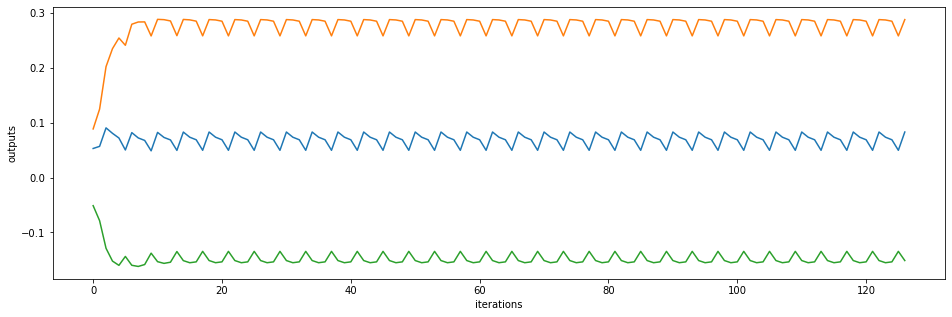

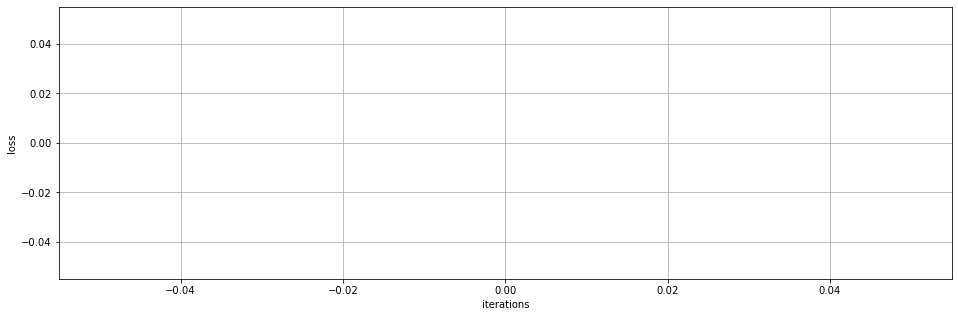

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 1
---------------
epoch 2
---------------
epoch 3
---------------
epoch 4
---------------
epoch 5
---------------
epoch 6
---------------
epoch 7
---------------
epoch 8
---------------
epoch 9
---------------
epoch 10
---------------
epoch 10
learning rate: 0.009972541205351565
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22068894]
 [0.28761986]
 [0.33809595]]


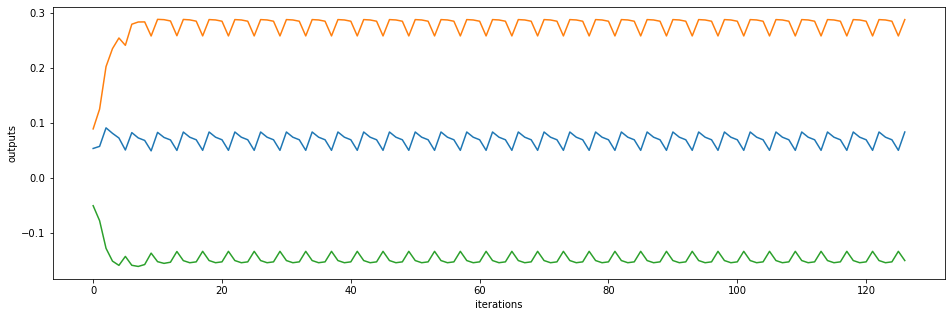

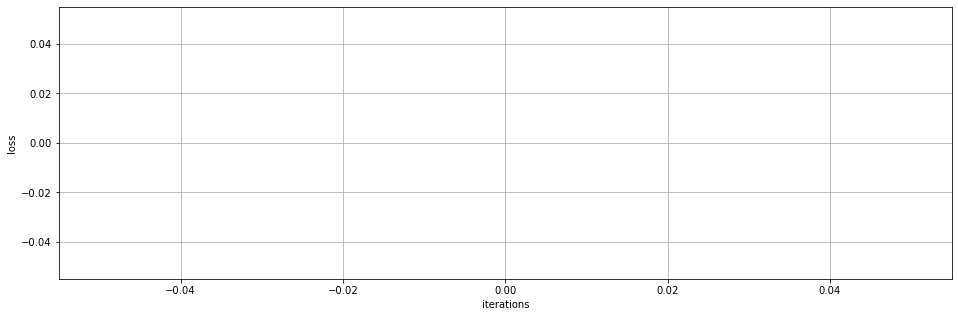

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 11
---------------
epoch 12
---------------
epoch 13
---------------
epoch 14
---------------
epoch 15
---------------
epoch 16
---------------
epoch 17
---------------
epoch 18
---------------
epoch 19
---------------
epoch 20
---------------
epoch 20
learning rate: 0.009947644098695797
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22070263]
 [0.2877005 ]
 [0.33797242]]


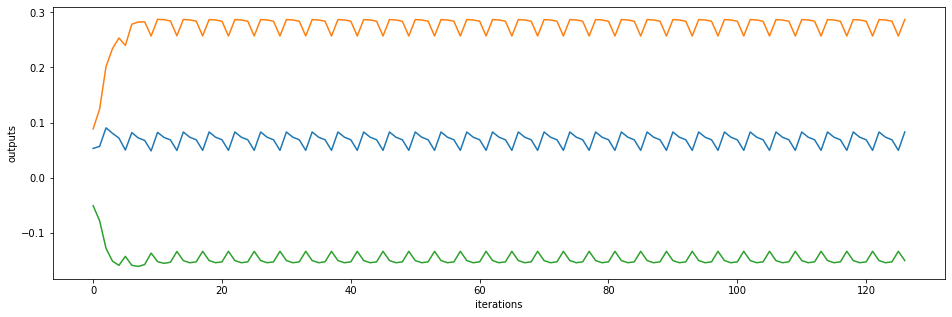

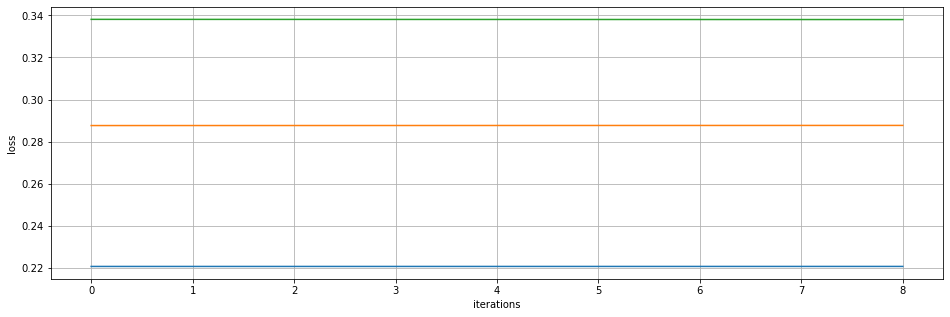

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 21
---------------
epoch 22
---------------
epoch 23
---------------
epoch 24
---------------
epoch 25
---------------
epoch 26
---------------
epoch 27
---------------
epoch 28
---------------
epoch 29
---------------
epoch 30
---------------
epoch 30
learning rate: 0.009922809149308376
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.220716  ]
 [0.28777992]
 [0.33785092]]


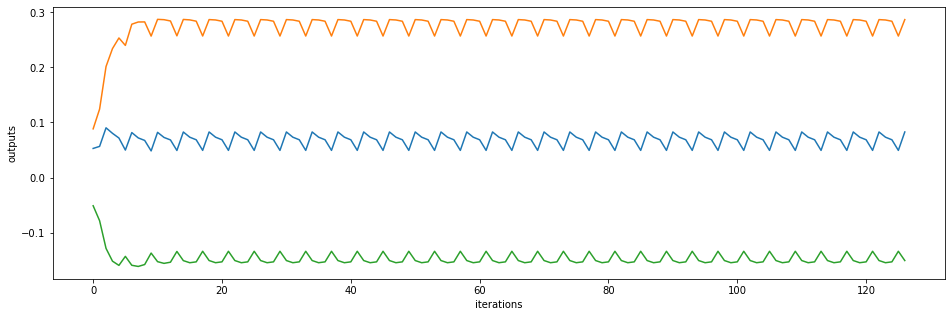

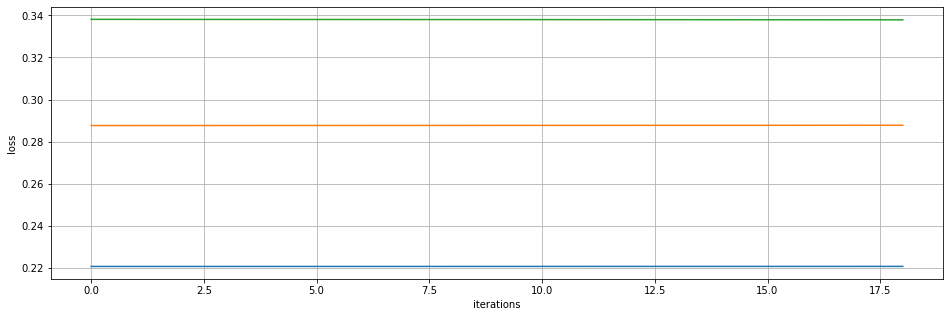

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 31
---------------
epoch 32
---------------
epoch 33
---------------
epoch 34
---------------
epoch 35
---------------
epoch 36
---------------
epoch 37
---------------
epoch 38
---------------
epoch 39
---------------
epoch 40
---------------
epoch 40
learning rate: 0.009898036202009583
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22072903]
 [0.28785807]
 [0.33773151]]


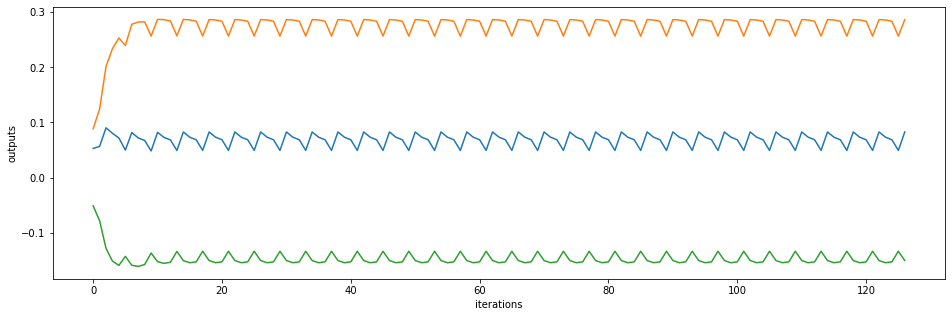

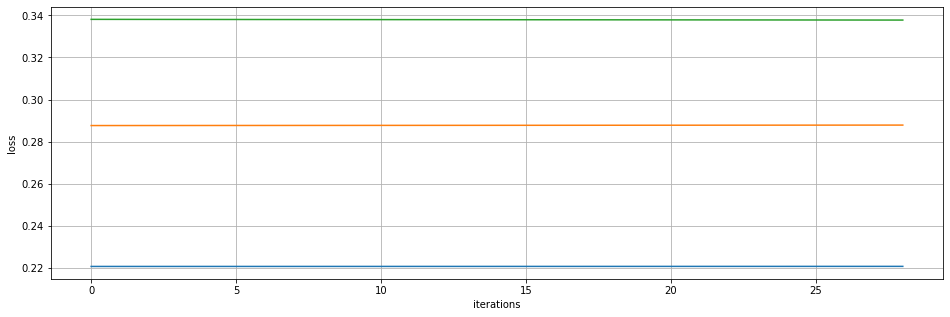

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 41
---------------
epoch 42
---------------
epoch 43
---------------
epoch 44
---------------
epoch 45
---------------
epoch 46
---------------
epoch 47
---------------
epoch 48
---------------
epoch 49
---------------
epoch 50
---------------
epoch 50
learning rate: 0.009873325102007122
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22074174]
 [0.28793491]
 [0.33761423]]


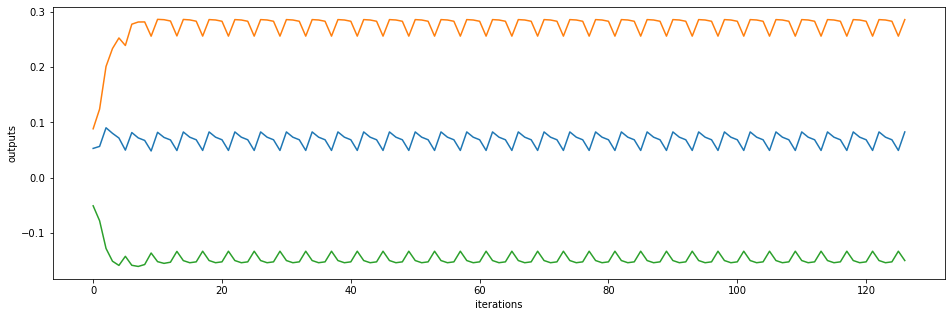

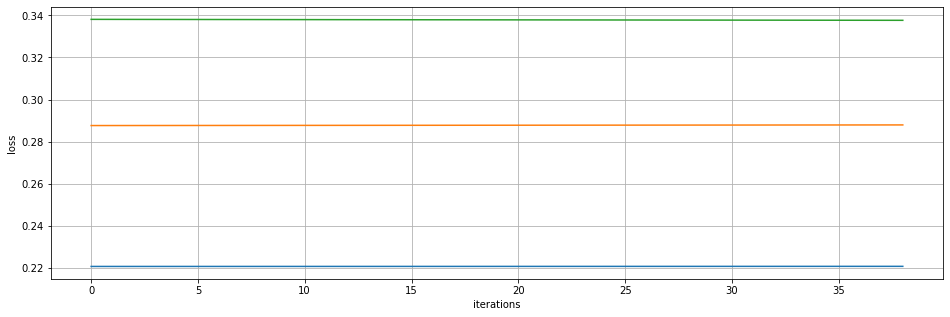

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 51
---------------
epoch 52
---------------
epoch 53
---------------
epoch 54
---------------
epoch 55
---------------
epoch 56
---------------
epoch 57
---------------
epoch 58
---------------
epoch 59
---------------
epoch 60
---------------
epoch 60
learning rate: 0.009848675694895137
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22075412]
 [0.28801041]
 [0.33749912]]


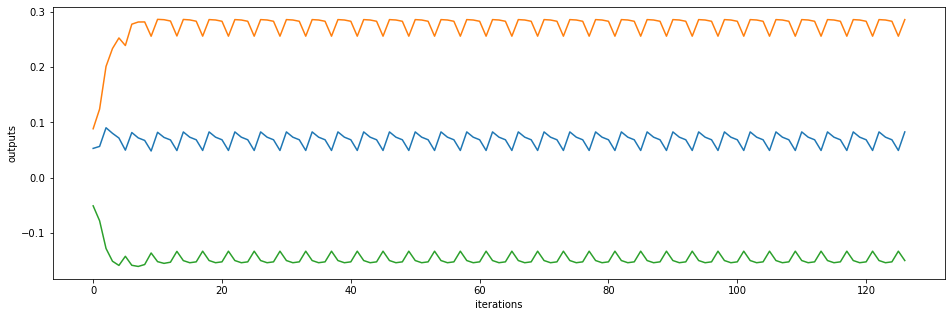

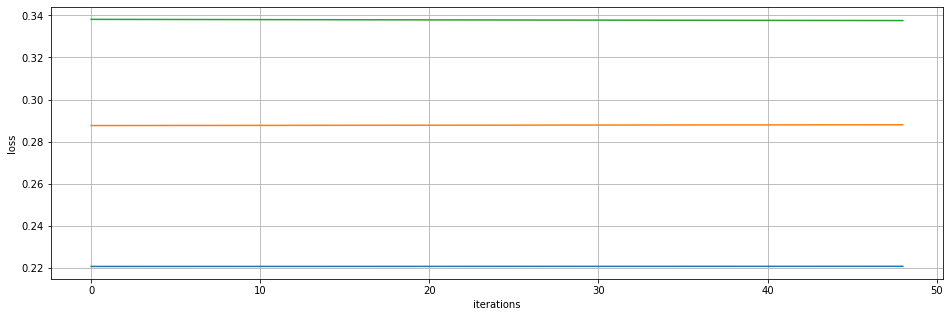

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 61
---------------
epoch 62
---------------
epoch 63
---------------
epoch 64
---------------
epoch 65
---------------
epoch 66
---------------
epoch 67
---------------
epoch 68
---------------
epoch 69
---------------
epoch 70
---------------
epoch 70
learning rate: 0.009824087826653255
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22076618]
 [0.28808454]
 [0.33738619]]


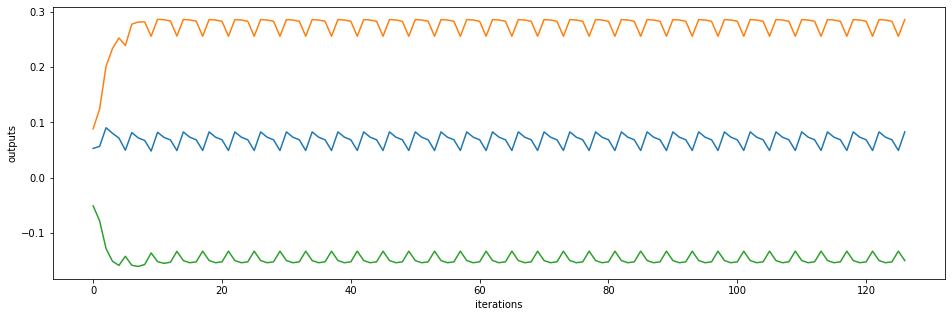

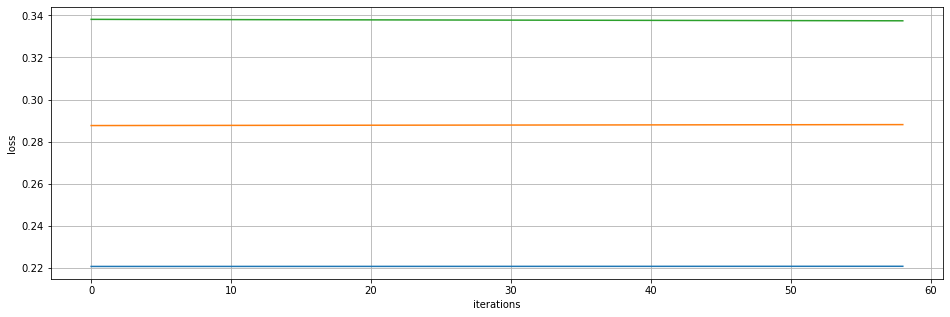

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 71
---------------
epoch 72
---------------
epoch 73
---------------
epoch 74
---------------
epoch 75
---------------
epoch 76
---------------
epoch 77
---------------
epoch 78
---------------
epoch 79
---------------
epoch 80
---------------
epoch 80
learning rate: 0.009799561343645635
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22077793]
 [0.28815727]
 [0.33727548]]


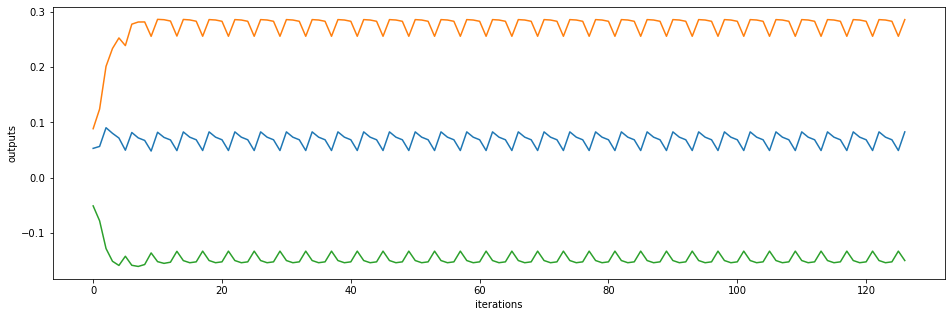

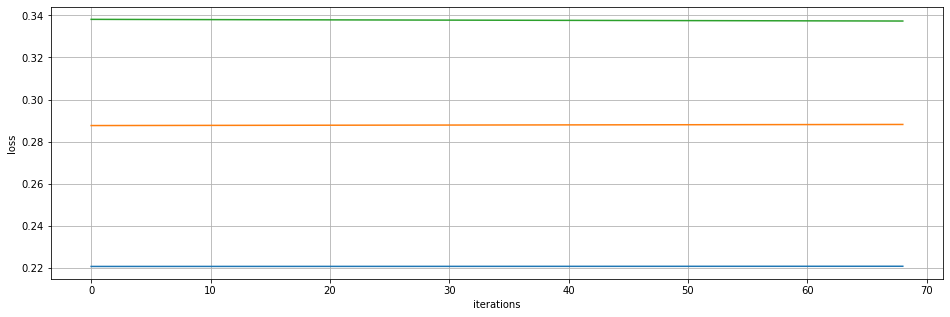

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 81
---------------
epoch 82
---------------
epoch 83
---------------
epoch 84
---------------
epoch 85
---------------
epoch 86
---------------
epoch 87
---------------
epoch 88
---------------
epoch 89
---------------
epoch 90
---------------
epoch 90
learning rate: 0.00977509609261999
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22078936]
 [0.28822858]
 [0.33716699]]


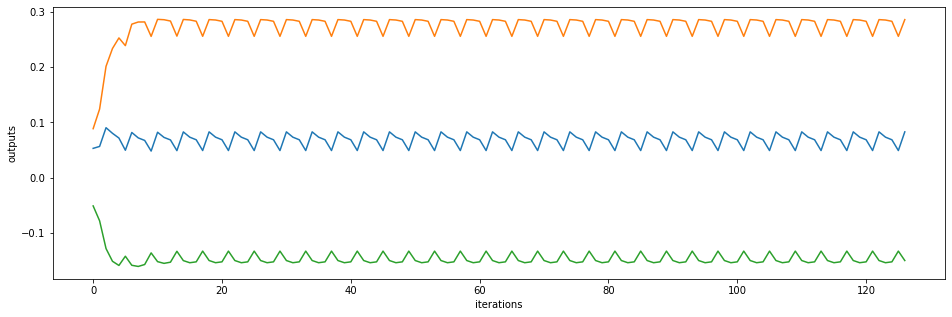

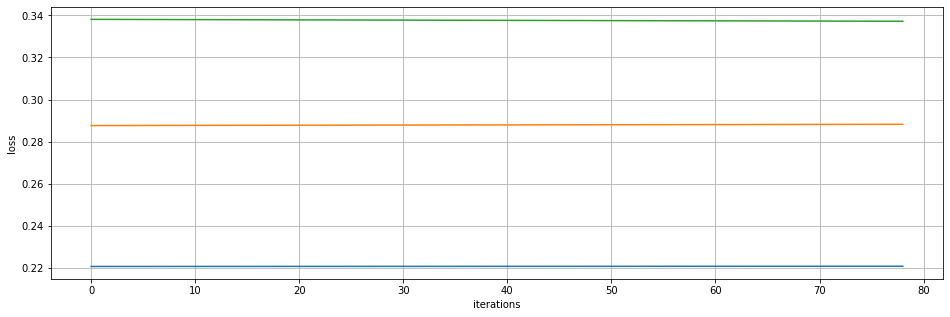

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 91
---------------
epoch 92
---------------
epoch 93
---------------
epoch 94
---------------
epoch 95
---------------
epoch 96
---------------
epoch 97
---------------
epoch 98
---------------
epoch 99
---------------
epoch 100
---------------
epoch 100
learning rate: 0.009750691920706642
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22080048]
 [0.28829845]
 [0.33706074]]


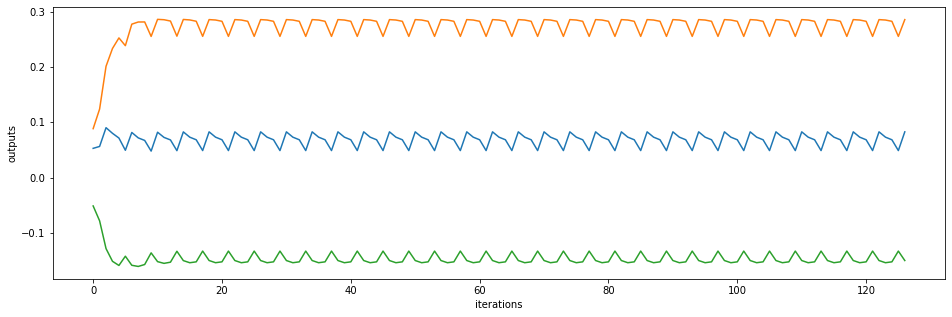

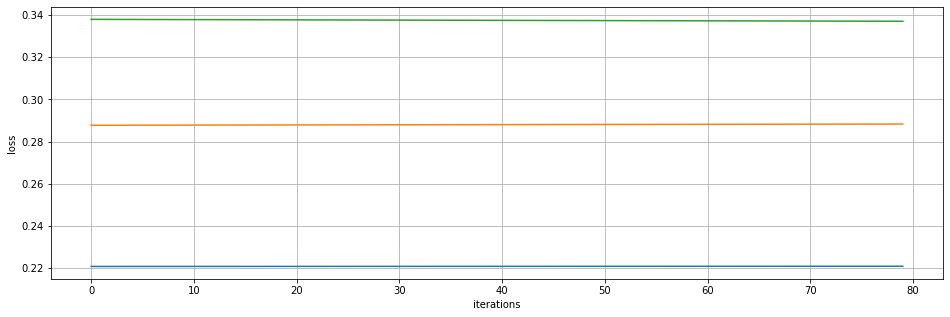

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 101
---------------
epoch 102
---------------
epoch 103
---------------
epoch 104
---------------
epoch 105
---------------
epoch 106
---------------
epoch 107
---------------
epoch 108
---------------
epoch 109
---------------
epoch 110
---------------
epoch 110
learning rate: 0.009726348675417556
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22081131]
 [0.28836688]
 [0.33695674]]


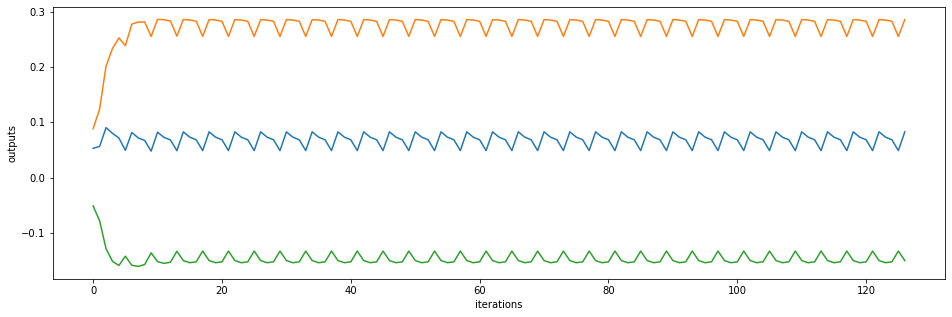

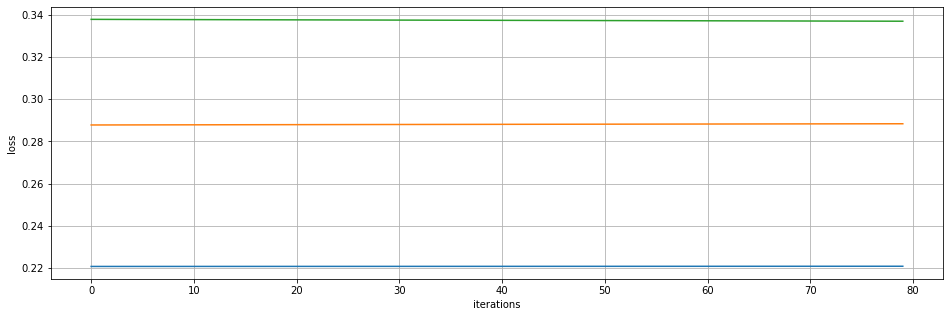

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 111
---------------
epoch 112
---------------
epoch 113
---------------
epoch 114
---------------
epoch 115
---------------
epoch 116
---------------
epoch 117
---------------
epoch 118
---------------
epoch 119
---------------
epoch 120
---------------
epoch 120
learning rate: 0.0097020662046454
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22082184]
 [0.28843385]
 [0.33685497]]


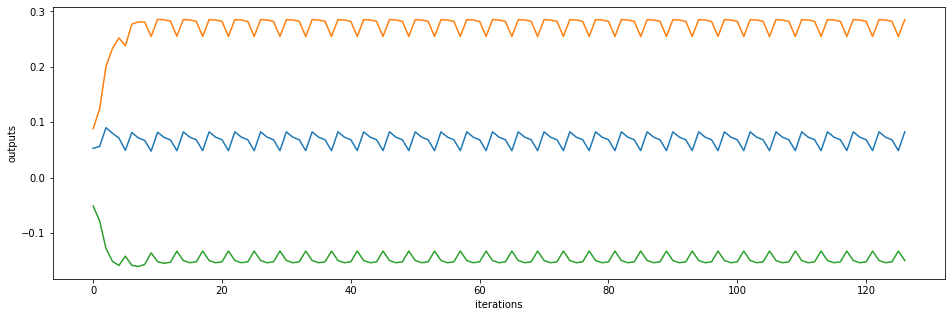

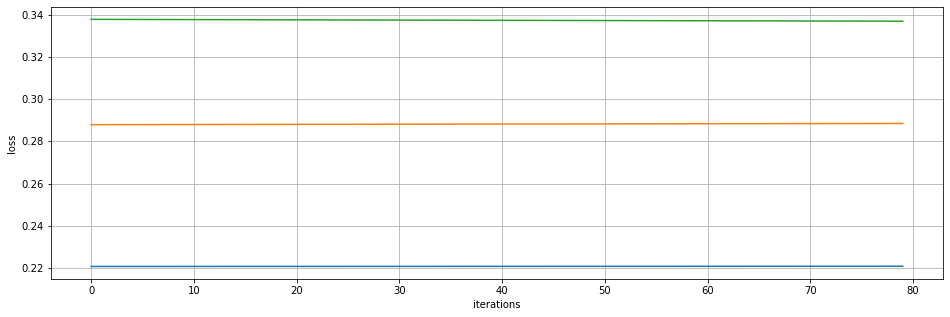

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 121
---------------
epoch 122
---------------
epoch 123
---------------
epoch 124
---------------
epoch 125
---------------
epoch 126
---------------
epoch 127
---------------
epoch 128
---------------
epoch 129
---------------
epoch 130
---------------
epoch 130
learning rate: 0.009677844356662583
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22083207]
 [0.28849937]
 [0.33675544]]


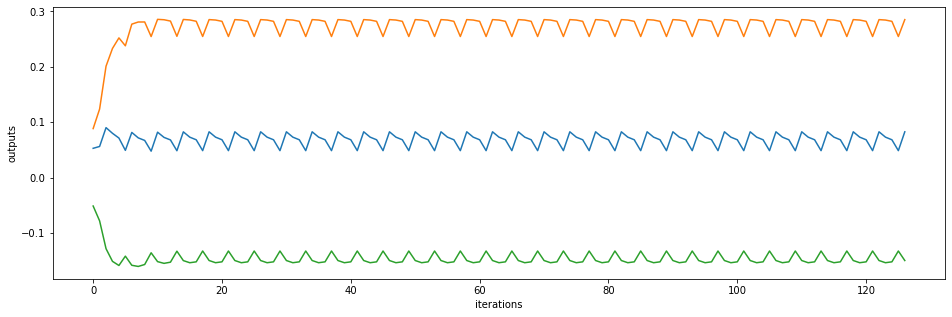

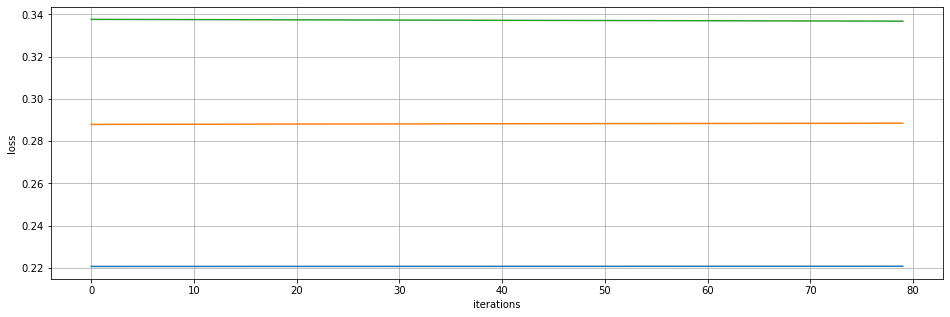

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 131
---------------
epoch 132
---------------
epoch 133
---------------
epoch 134
---------------
epoch 135
---------------
epoch 136
---------------
epoch 137
---------------
epoch 138
---------------
epoch 139
---------------
epoch 140
---------------
epoch 140
learning rate: 0.009653682980120315
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22084202]
 [0.28856342]
 [0.33665813]]


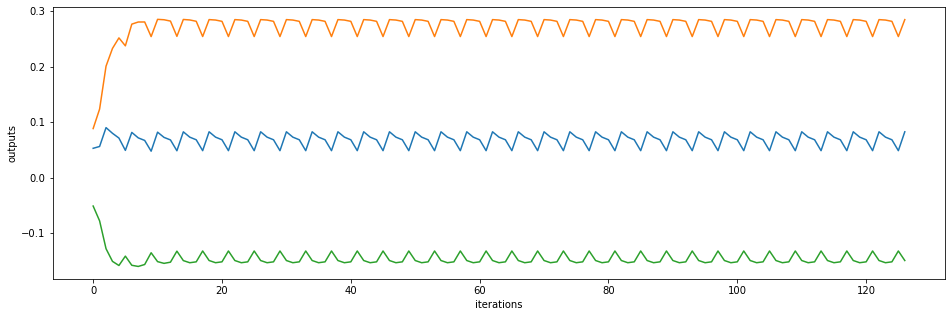

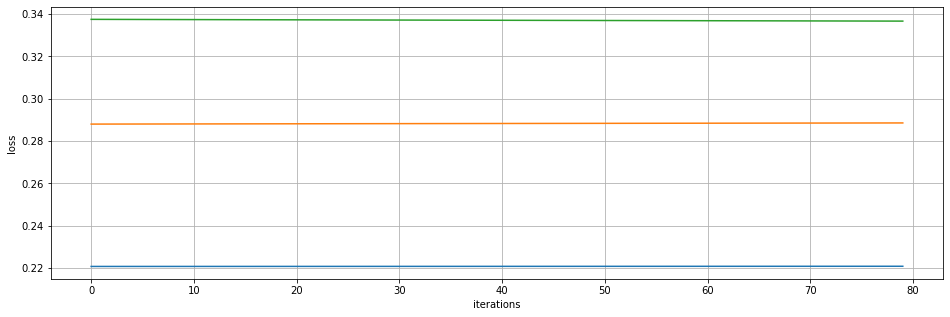

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 141
---------------
epoch 142
---------------
epoch 143
---------------
epoch 144
---------------
epoch 145
---------------
epoch 146
---------------
epoch 147
---------------
epoch 148
---------------
epoch 149
---------------
epoch 150
---------------
epoch 150
learning rate: 0.009629581924047658
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22085169]
 [0.28862601]
 [0.33656303]]


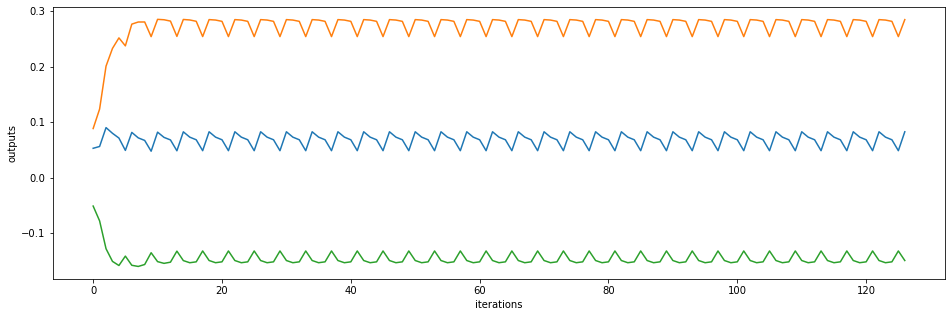

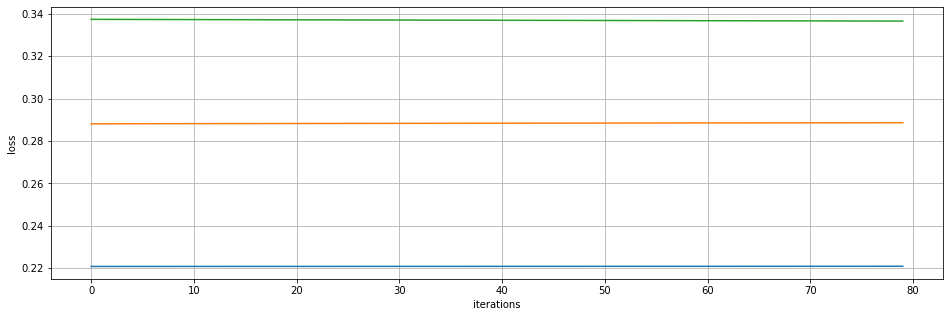

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 151
---------------
epoch 152
---------------
epoch 153
---------------
epoch 154
---------------
epoch 155
---------------
epoch 156
---------------
epoch 157
---------------
epoch 158
---------------
epoch 159
---------------
epoch 160
---------------
epoch 160
learning rate: 0.00960554103785058
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22086108]
 [0.28868715]
 [0.33647011]]


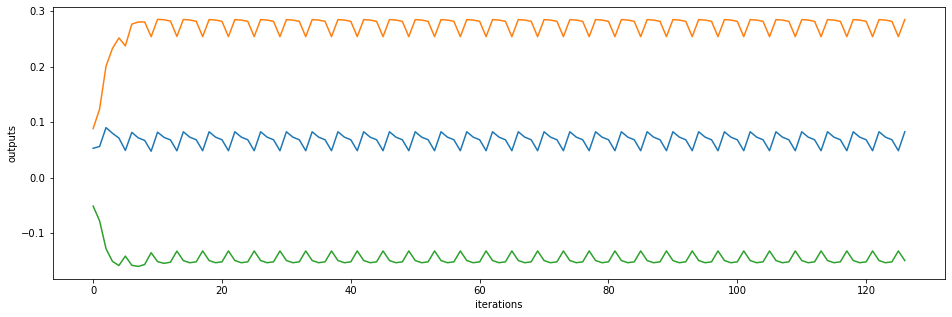

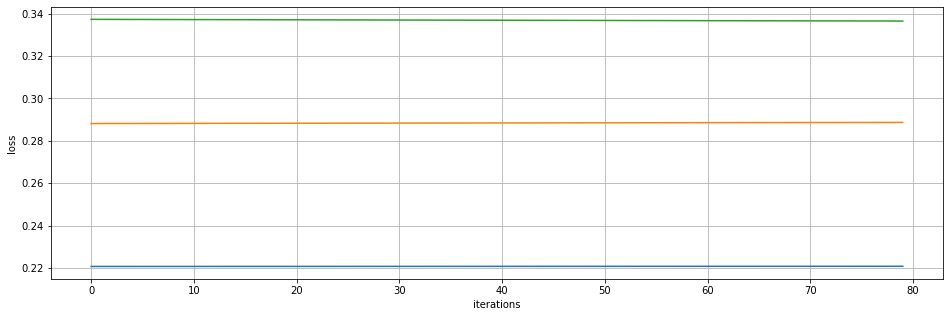

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 161
---------------
epoch 162
---------------
epoch 163
---------------
epoch 164
---------------
epoch 165
---------------
epoch 166
---------------
epoch 167
---------------
epoch 168
---------------
epoch 169
---------------
epoch 170
---------------
epoch 170
learning rate: 0.009581560171311024
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22087021]
 [0.28874685]
 [0.33637937]]


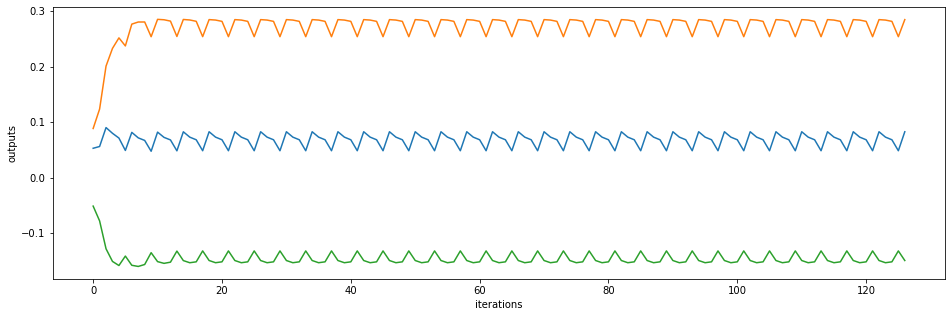

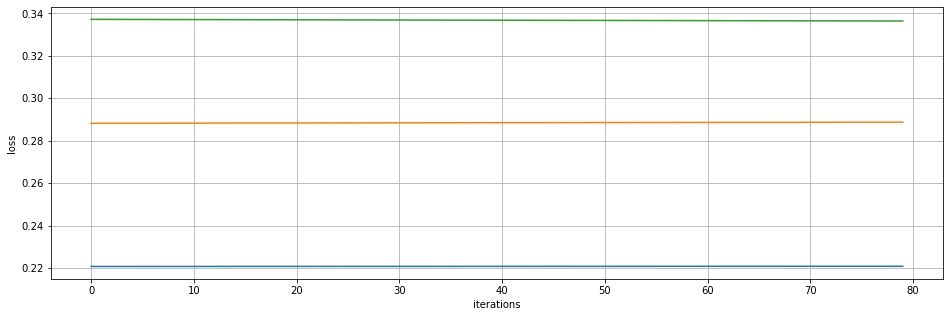

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 171
---------------
epoch 172
---------------
epoch 173
---------------
epoch 174
---------------
epoch 175
---------------
epoch 176
---------------
epoch 177
---------------
epoch 178
---------------
epoch 179
---------------
epoch 180
---------------
epoch 180
learning rate: 0.009557639174585955
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22087907]
 [0.28880511]
 [0.33629076]]


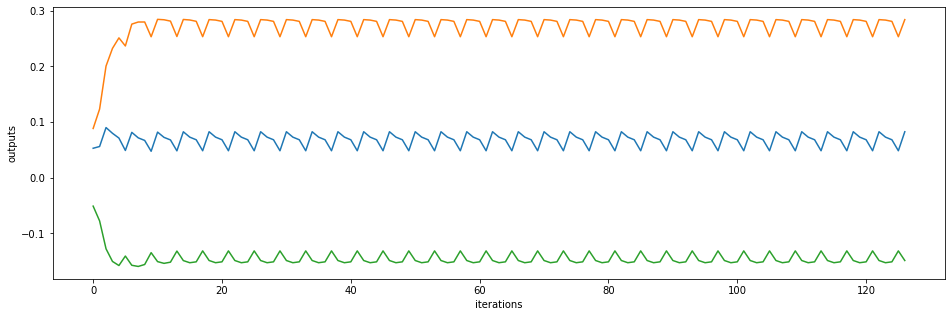

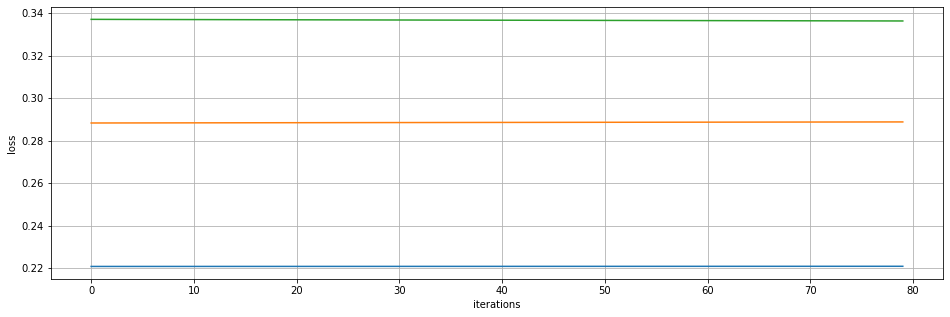

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 181
---------------
epoch 182
---------------
epoch 183
---------------
epoch 184
---------------
epoch 185
---------------
epoch 186
---------------
epoch 187
---------------
epoch 188
---------------
epoch 189
---------------
epoch 190
---------------
epoch 190
learning rate: 0.009533777898206437
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22088767]
 [0.28886196]
 [0.33620427]]


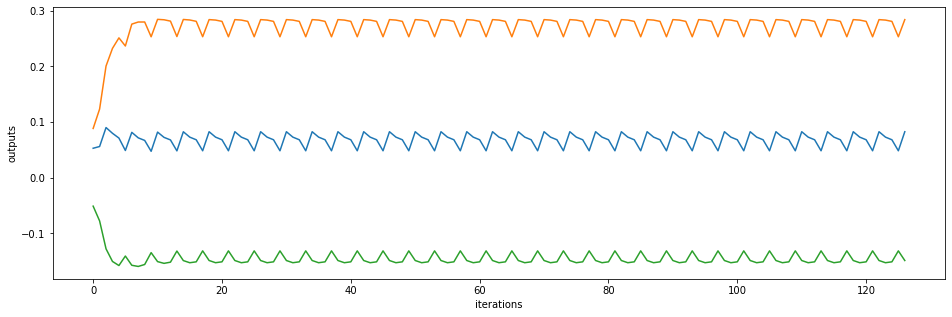

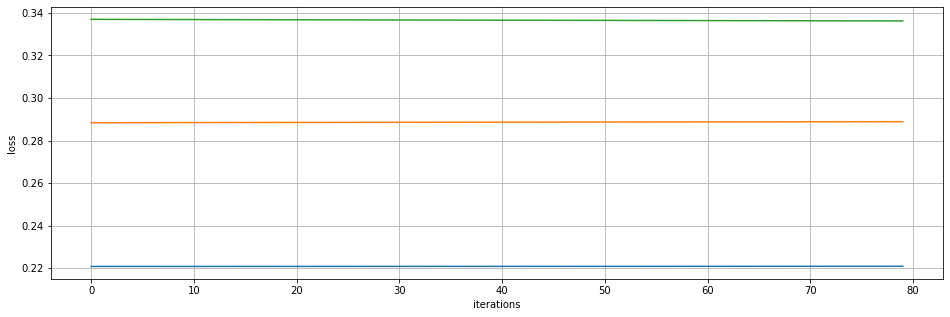

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 191
---------------
epoch 192
---------------
epoch 193
---------------
epoch 194
---------------
epoch 195
---------------
epoch 196
---------------
epoch 197
---------------
epoch 198
---------------
epoch 199
---------------
epoch 200
---------------
epoch 200
learning rate: 0.009509976193076683
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22089602]
 [0.2889174 ]
 [0.33611985]]


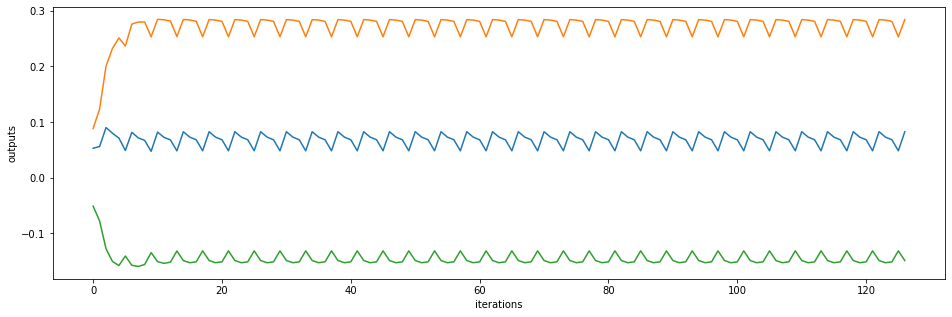

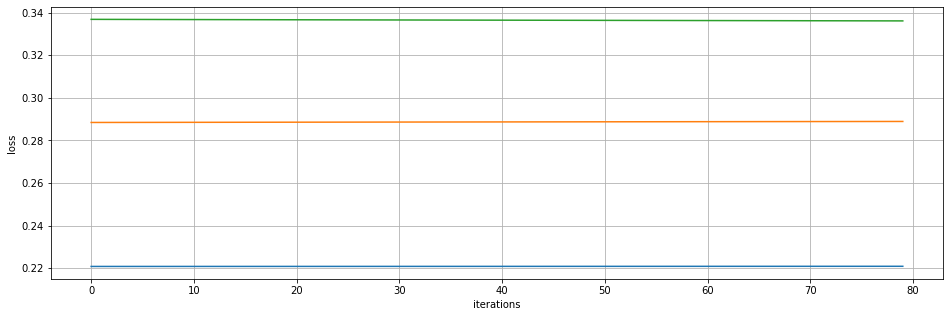

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 201
---------------
epoch 202
---------------
epoch 203
---------------
epoch 204
---------------
epoch 205
---------------
epoch 206
---------------
epoch 207
---------------
epoch 208
---------------
epoch 209
---------------
epoch 210
---------------
epoch 210
learning rate: 0.009486233910473145
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22090413]
 [0.28897145]
 [0.33603749]]


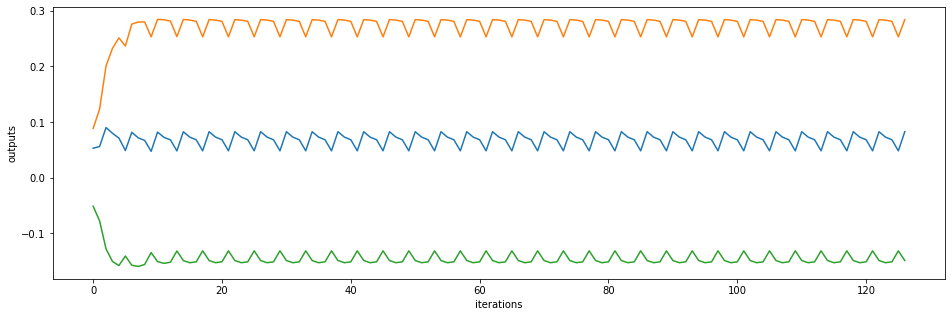

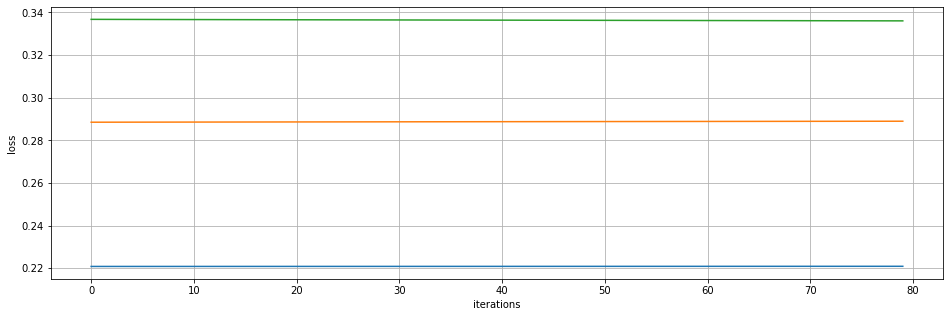

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 211
---------------
epoch 212
---------------
epoch 213
---------------
epoch 214
---------------
epoch 215
---------------
epoch 216
---------------
epoch 217
---------------
epoch 218
---------------
epoch 219
---------------
epoch 220
---------------
epoch 220
learning rate: 0.009462550902043567
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.220912  ]
 [0.28902414]
 [0.33595713]]


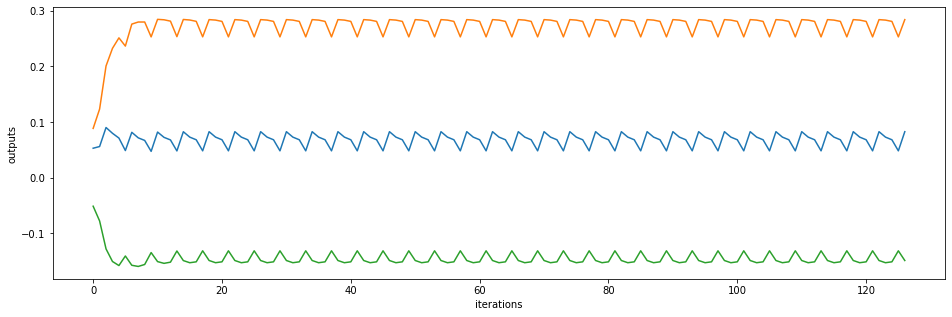

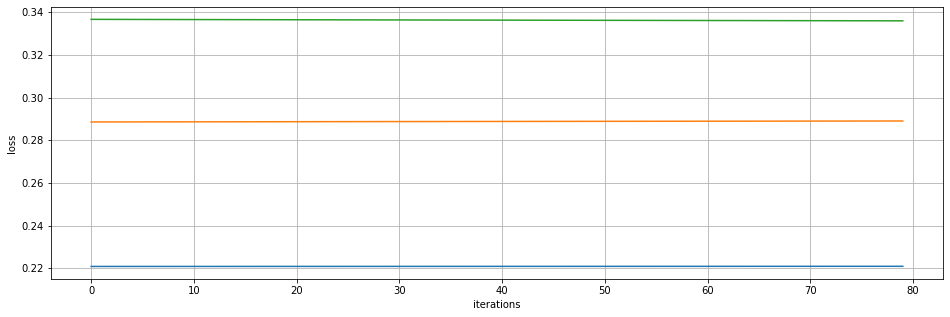

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 221
---------------
epoch 222
---------------
epoch 223
---------------
epoch 224
---------------
epoch 225
---------------
epoch 226
---------------
epoch 227
---------------
epoch 228
---------------
epoch 229
---------------
epoch 230
---------------
epoch 230
learning rate: 0.009438927019806066
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22091963]
 [0.28907548]
 [0.33587876]]


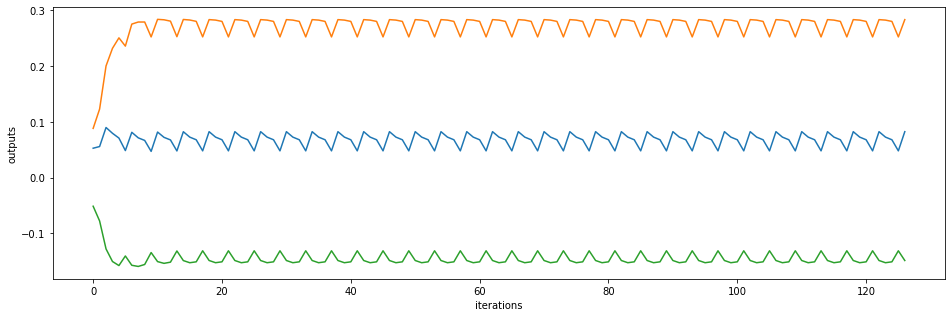

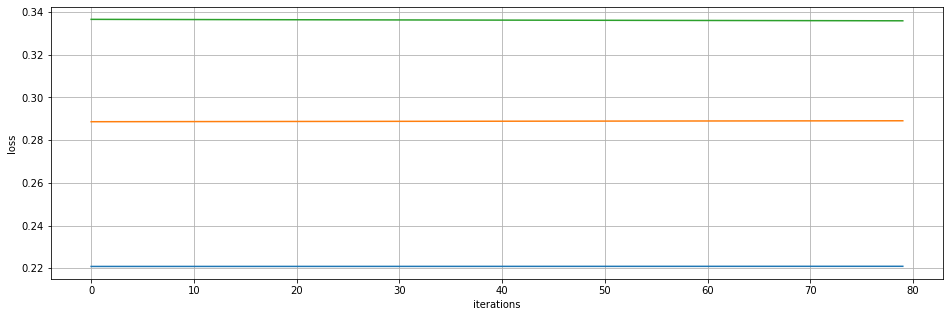

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 231
---------------
epoch 232
---------------
epoch 233
---------------
epoch 234
---------------
epoch 235
---------------
epoch 236
---------------
epoch 237
---------------
epoch 238
---------------
epoch 239
---------------
epoch 240
---------------
epoch 240
learning rate: 0.009415362116148207
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22092703]
 [0.2891255 ]
 [0.33580232]]


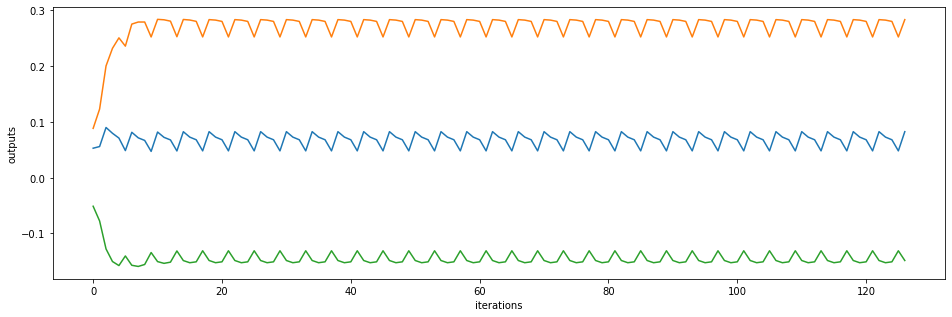

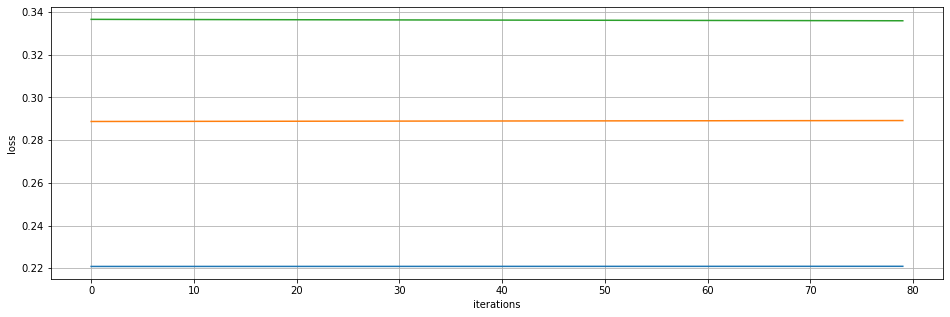

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 241
---------------
epoch 242
---------------
epoch 243
---------------
epoch 244
---------------
epoch 245
---------------
epoch 246
---------------
epoch 247
---------------
epoch 248
---------------
epoch 249
---------------
epoch 250
---------------
epoch 250
learning rate: 0.009391856043826073
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22093421]
 [0.28917422]
 [0.33572778]]


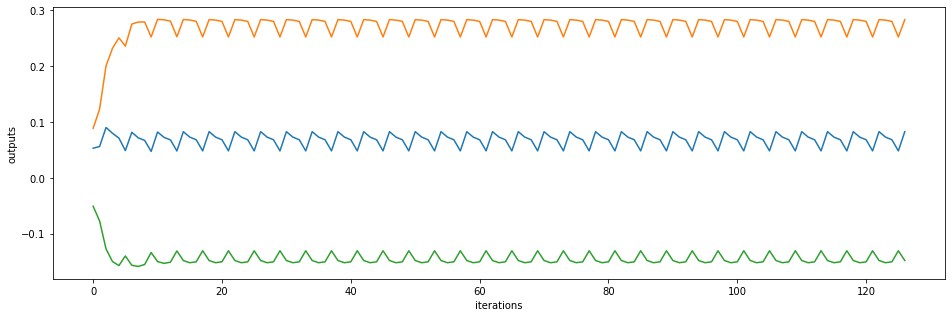

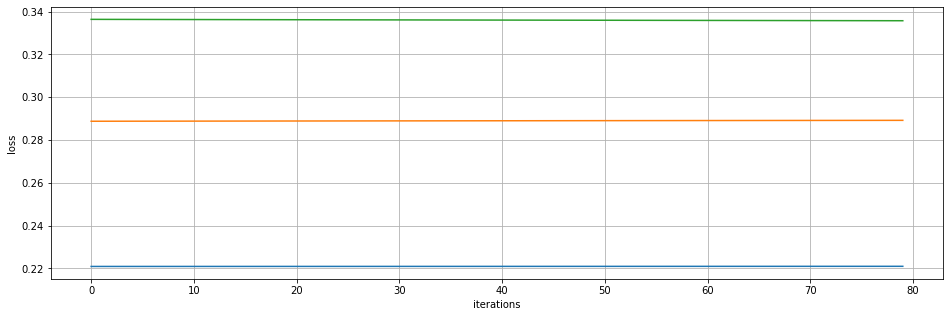

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 251
---------------
epoch 252
---------------
epoch 253
---------------
epoch 254
---------------
epoch 255
---------------
epoch 256
---------------
epoch 257
---------------
epoch 258
---------------
epoch 259
---------------
epoch 260
---------------
epoch 260
learning rate: 0.009368408655963358
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22094117]
 [0.28922166]
 [0.3356551 ]]


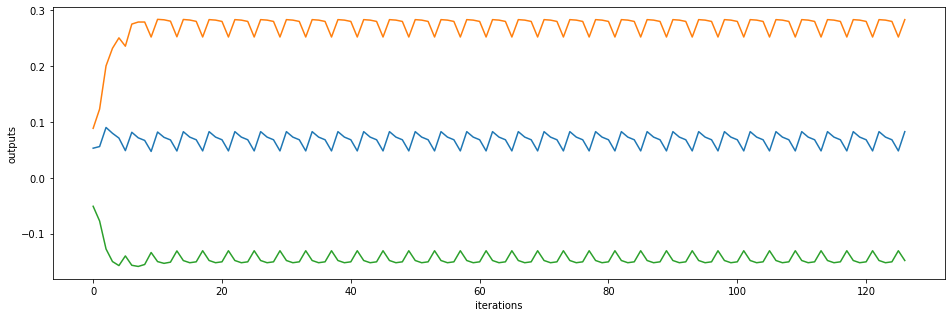

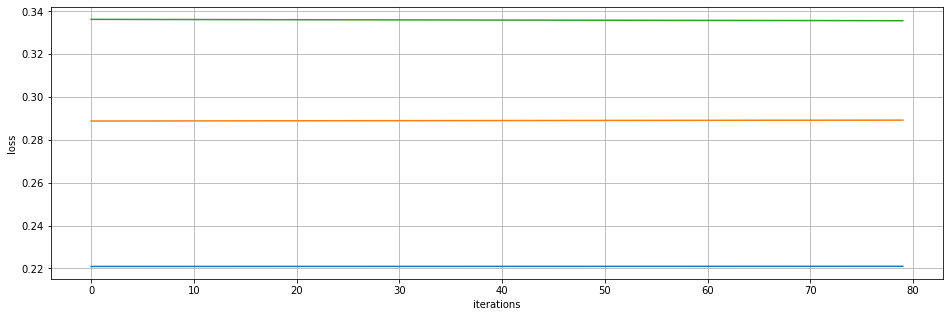

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 261
---------------
epoch 262
---------------
epoch 263
---------------
epoch 264
---------------
epoch 265
---------------
epoch 266
---------------
epoch 267
---------------
epoch 268
---------------
epoch 269
---------------
epoch 270
---------------
epoch 270
learning rate: 0.00934501980605044
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22094792]
 [0.28926784]
 [0.33558424]]


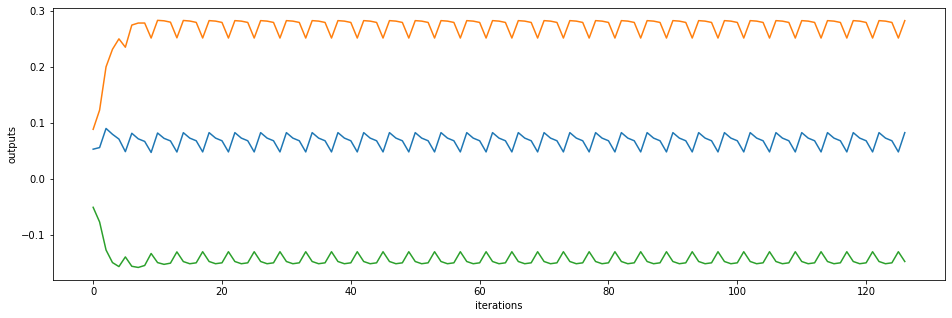

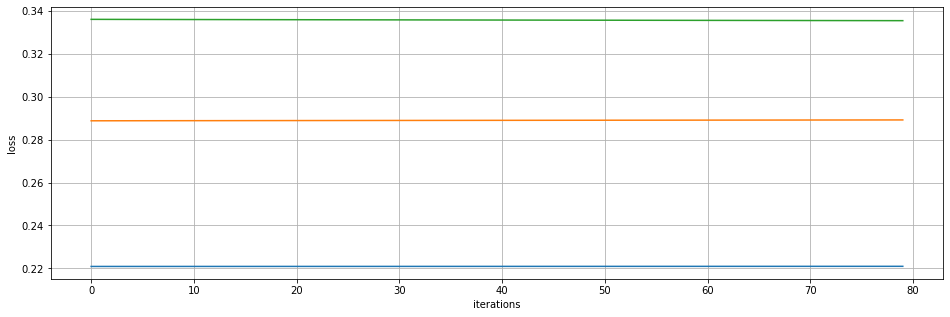

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 271
---------------
epoch 272
---------------
epoch 273
---------------
epoch 274
---------------
epoch 275
---------------
epoch 276
---------------
epoch 277
---------------
epoch 278
---------------
epoch 279
---------------
epoch 280
---------------
epoch 280
learning rate: 0.009321689347943467
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22095446]
 [0.2893128 ]
 [0.33551516]]


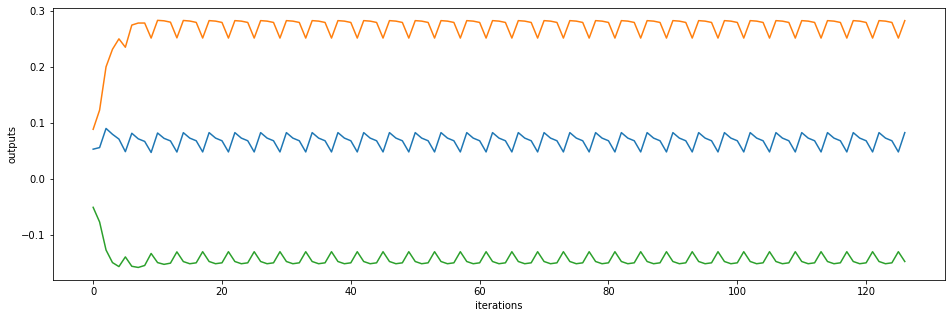

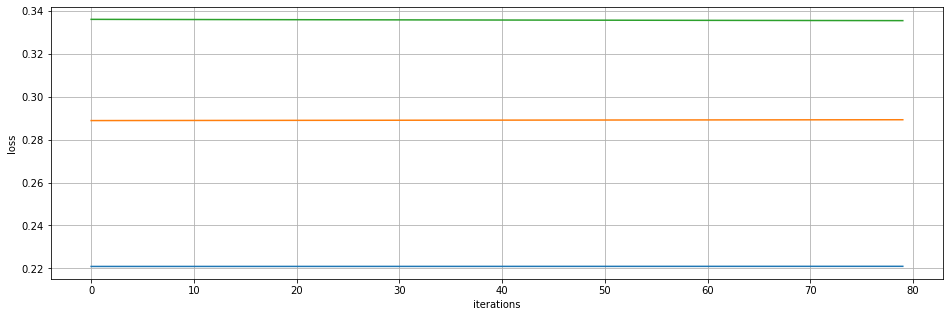

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 281
---------------
epoch 282
---------------
epoch 283
---------------
epoch 284
---------------
epoch 285
---------------
epoch 286
---------------
epoch 287
---------------
epoch 288
---------------
epoch 289
---------------
epoch 290
---------------
epoch 290
learning rate: 0.009298417135863445
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22096081]
 [0.28935656]
 [0.33544782]]


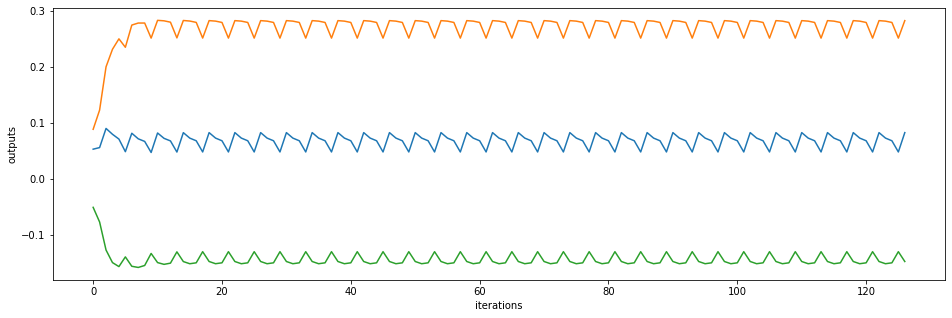

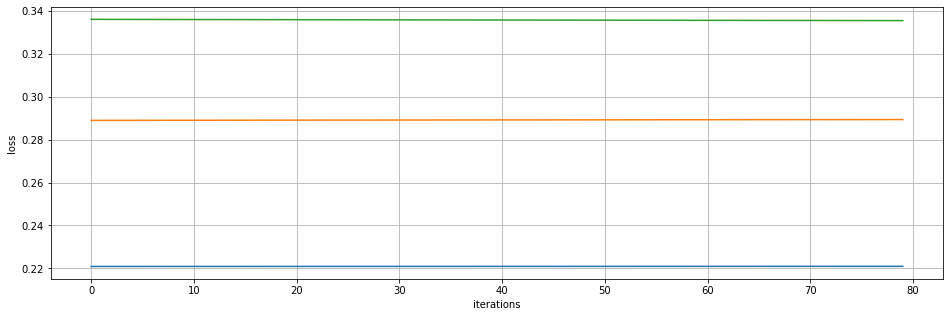

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 291
---------------
epoch 292
---------------
epoch 293
---------------
epoch 294
---------------
epoch 295
---------------
epoch 296
---------------
epoch 297
---------------
epoch 298
---------------
epoch 299
---------------
epoch 300
---------------
epoch 300
learning rate: 0.009275203024395329
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22096695]
 [0.28939914]
 [0.33538217]]


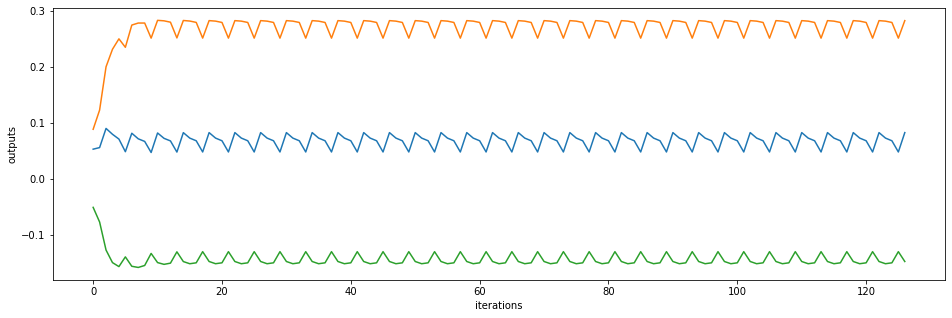

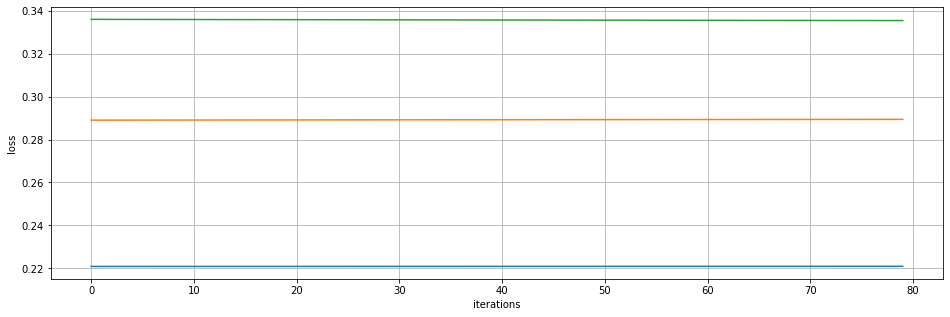

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 301
---------------
epoch 302
---------------
epoch 303
---------------
epoch 304
---------------
epoch 305
---------------
epoch 306
---------------
epoch 307
---------------
epoch 308
---------------
epoch 309
---------------
epoch 310
---------------
epoch 310
learning rate: 0.009252046868487105
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22097291]
 [0.28944057]
 [0.33531817]]


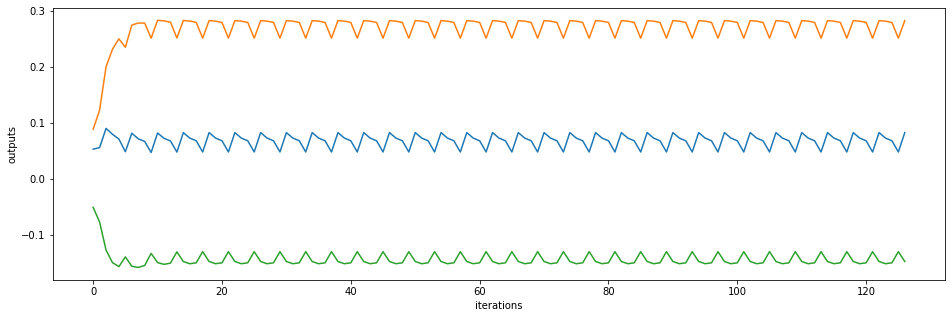

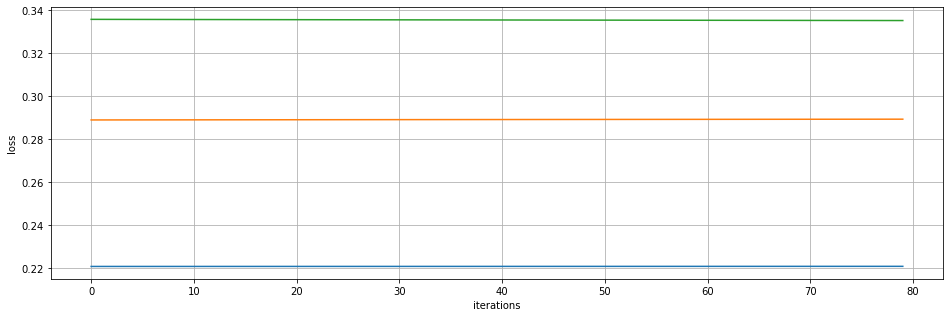

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 311
---------------
epoch 312
---------------
epoch 313
---------------
epoch 314
---------------
epoch 315
---------------
epoch 316
---------------
epoch 317
---------------
epoch 318
---------------
epoch 319
---------------
epoch 320
---------------
epoch 320
learning rate: 0.009228948523448898
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22097868]
 [0.28948088]
 [0.33525579]]


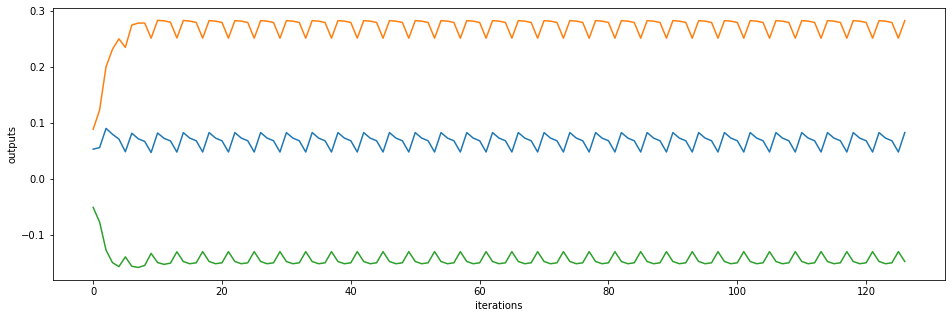

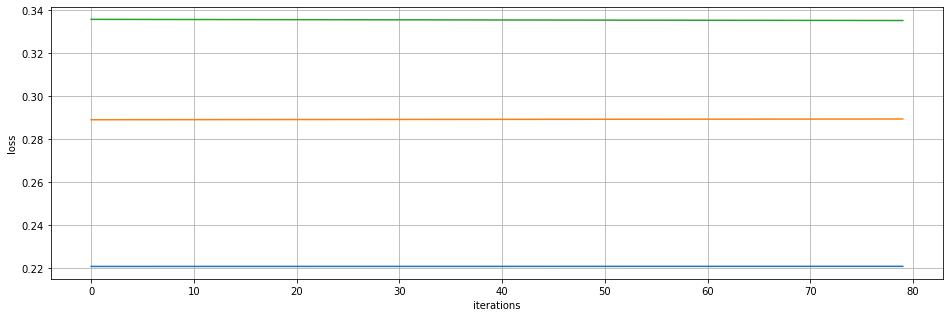

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 321
---------------
epoch 322
---------------
epoch 323
---------------
epoch 324
---------------
epoch 325
---------------
epoch 326
---------------
epoch 327
---------------
epoch 328
---------------
epoch 329
---------------
epoch 330
---------------
epoch 330
learning rate: 0.009205907844952064
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22098426]
 [0.2895201 ]
 [0.33519497]]


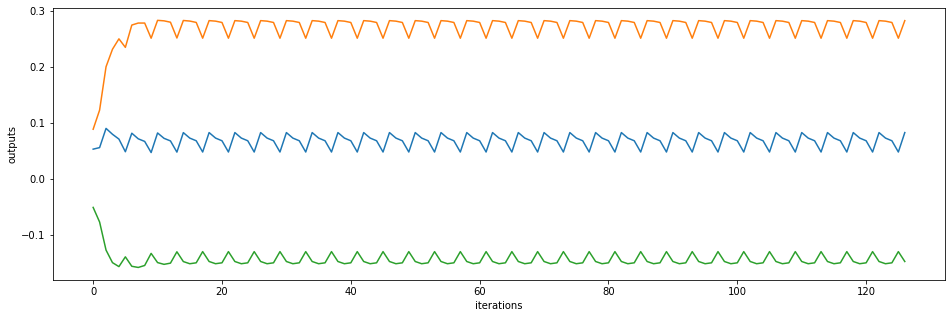

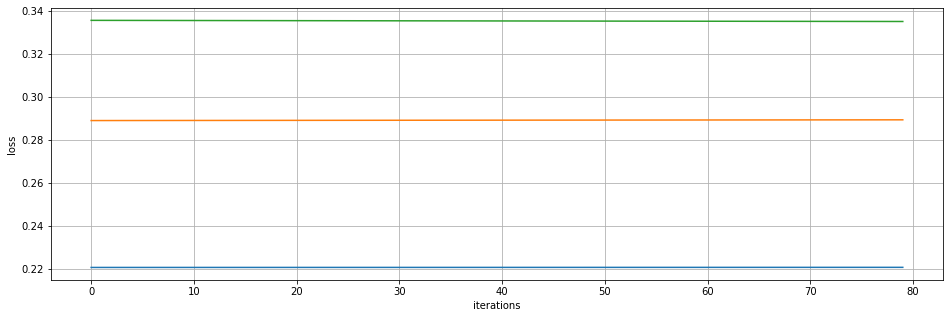

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 331
---------------
epoch 332
---------------
epoch 333
---------------
epoch 334
---------------
epoch 335
---------------
epoch 336
---------------
epoch 337
---------------
epoch 338
---------------
epoch 339
---------------
epoch 340
---------------
epoch 340
learning rate: 0.00918292468902828
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22098967]
 [0.28955824]
 [0.33513569]]


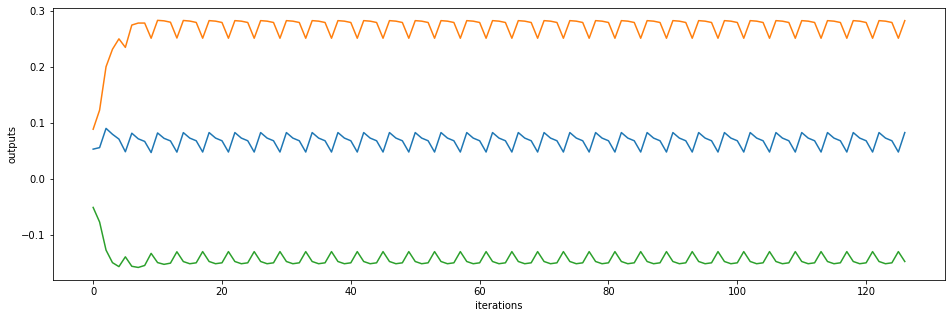

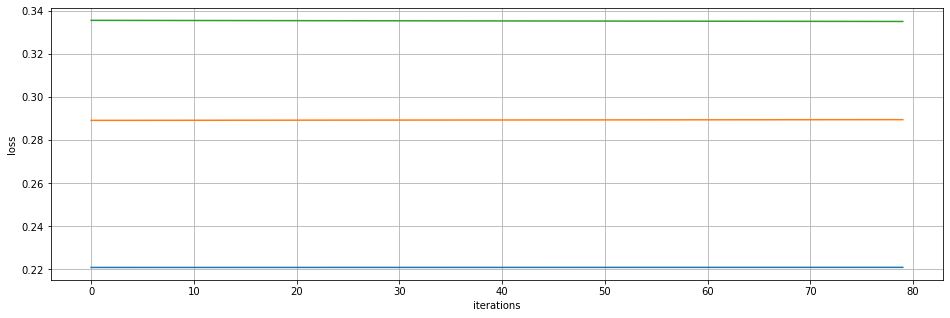

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 341
---------------
epoch 342
---------------
epoch 343
---------------
epoch 344
---------------
epoch 345
---------------
epoch 346
---------------
epoch 347
---------------
epoch 348
---------------
epoch 349
---------------
epoch 350
---------------
epoch 350
learning rate: 0.009159998912068647
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22099491]
 [0.28959535]
 [0.3350779 ]]


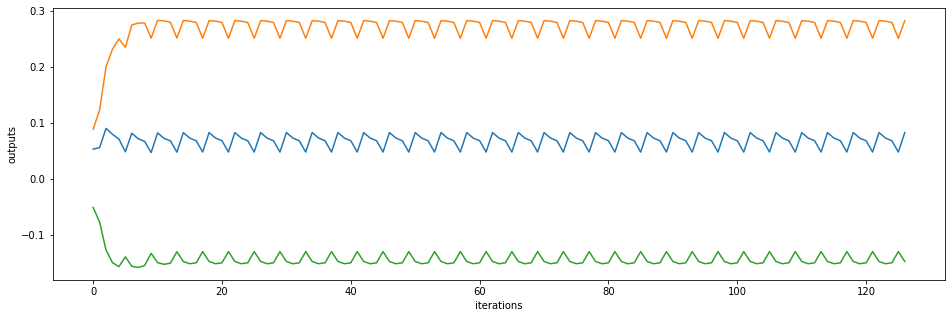

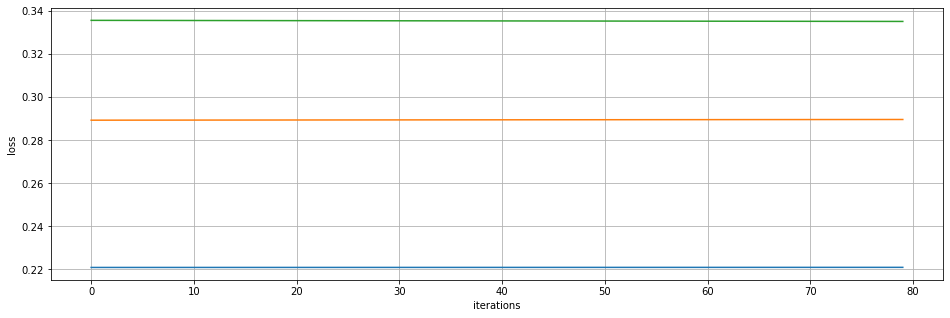

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 351
---------------
epoch 352
---------------
epoch 353
---------------
epoch 354
---------------
epoch 355
---------------
epoch 356
---------------
epoch 357
---------------
epoch 358
---------------
epoch 359
---------------
epoch 360
---------------
epoch 360
learning rate: 0.009137130370822796
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22099998]
 [0.28963143]
 [0.33502156]]


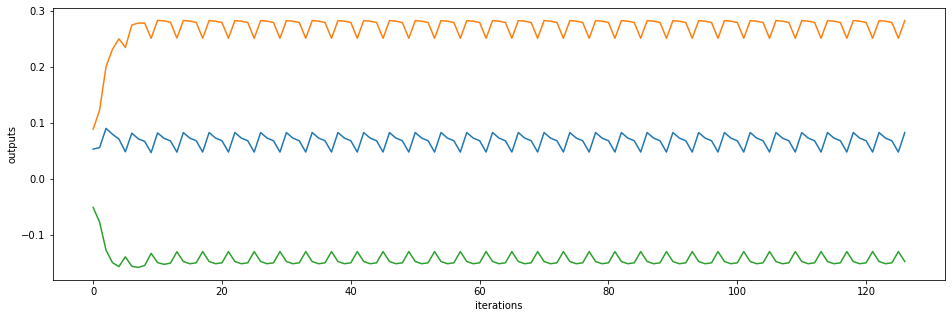

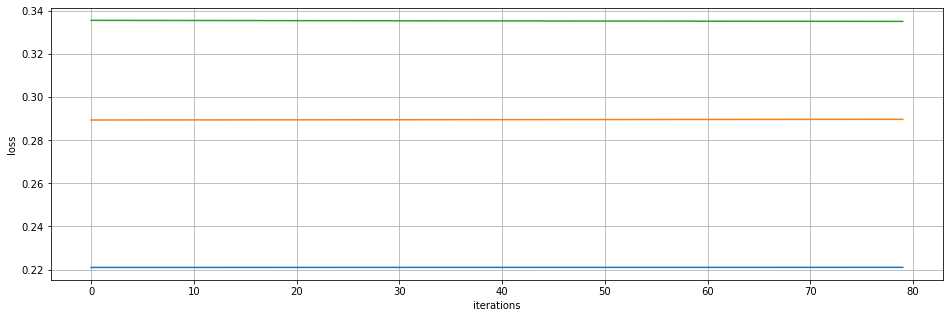

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 361
---------------
epoch 362
---------------
epoch 363
---------------
epoch 364
---------------
epoch 365
---------------
epoch 366
---------------
epoch 367
---------------
epoch 368
---------------
epoch 369
---------------
epoch 370
---------------
epoch 370
learning rate: 0.009114318922397998
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22100489]
 [0.28966653]
 [0.33496663]]


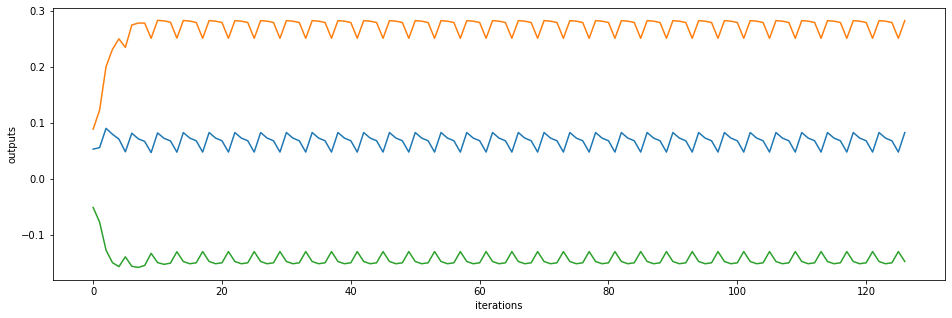

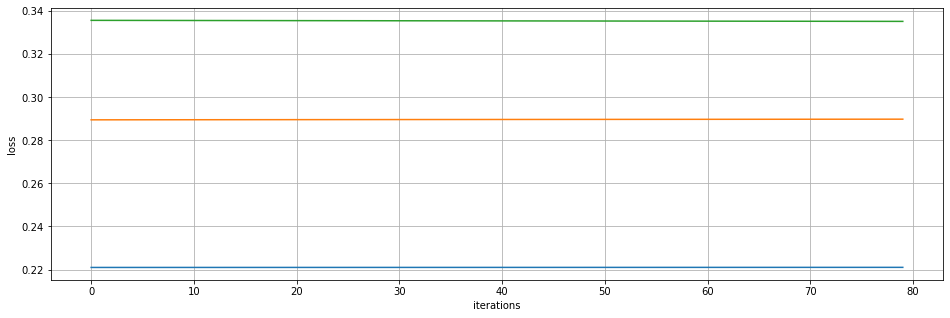

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 371
---------------
epoch 372
---------------
epoch 373
---------------
epoch 374
---------------
epoch 375
---------------
epoch 376
---------------
epoch 377
---------------
epoch 378
---------------
epoch 379
---------------
epoch 380
---------------
epoch 380
learning rate: 0.009091564424258259
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22100964]
 [0.28970066]
 [0.33491308]]


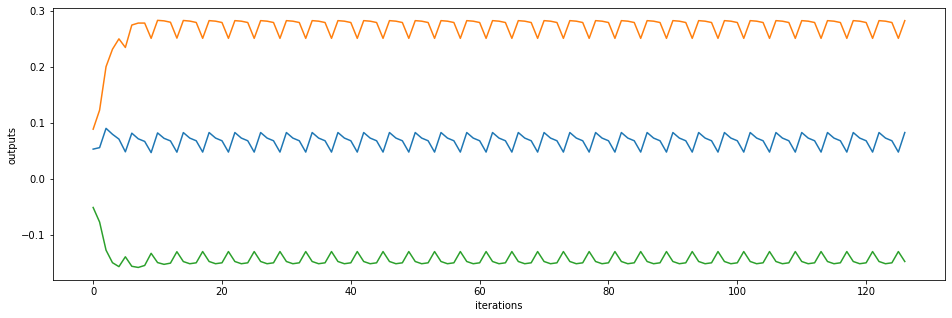

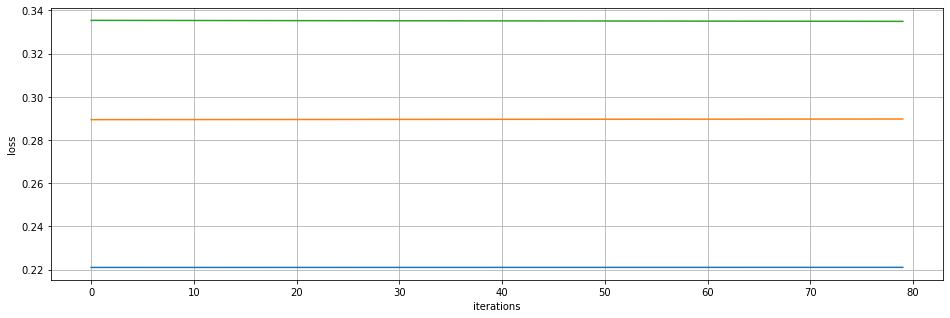

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 381
---------------
epoch 382
---------------
epoch 383
---------------
epoch 384
---------------
epoch 385
---------------
epoch 386
---------------
epoch 387
---------------
epoch 388
---------------
epoch 389
---------------
epoch 390
---------------
epoch 390
learning rate: 0.009068866734223436
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22101424]
 [0.28973385]
 [0.33486086]]


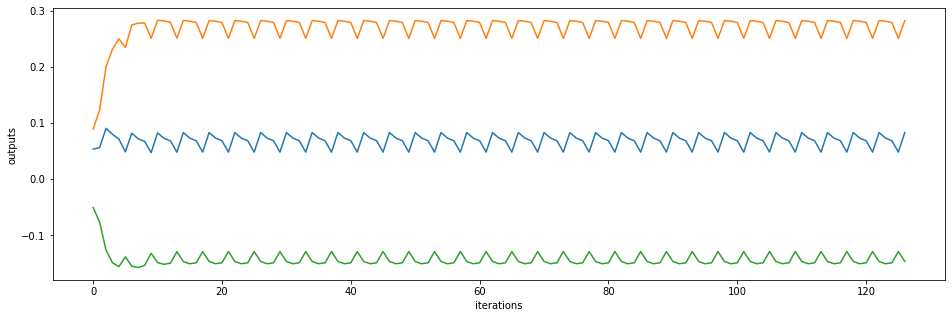

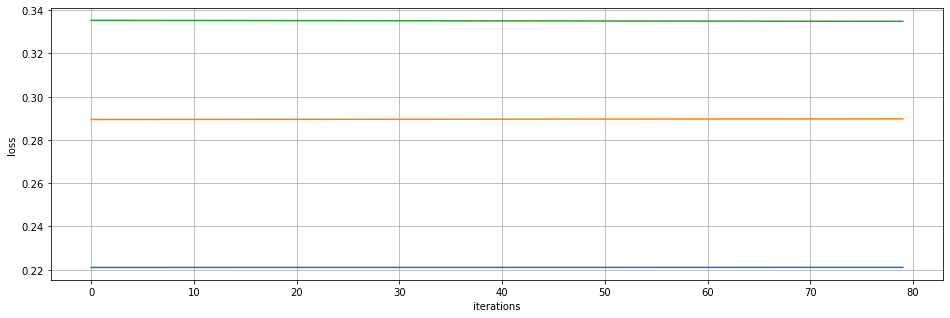

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 391
---------------
epoch 392
---------------
epoch 393
---------------
epoch 394
---------------
epoch 395
---------------
epoch 396
---------------
epoch 397
---------------
epoch 398
---------------
epoch 399
---------------
epoch 400
---------------
epoch 400
learning rate: 0.00904622571046835
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22101868]
 [0.28976613]
 [0.33480993]]


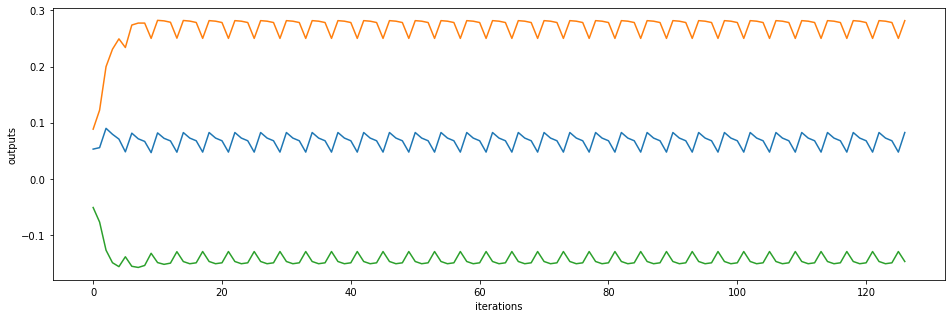

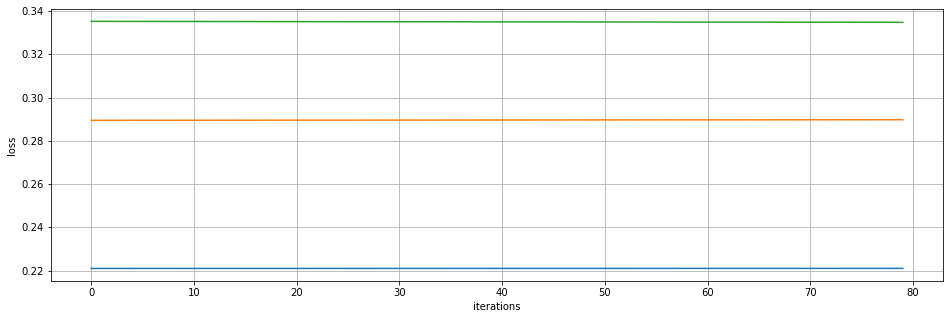

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 401
---------------
epoch 402
---------------
epoch 403
---------------
epoch 404
---------------
epoch 405
---------------
epoch 406
---------------
epoch 407
---------------
epoch 408
---------------
epoch 409
---------------
epoch 410
---------------
epoch 410
learning rate: 0.0090236412115219
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22102298]
 [0.28979752]
 [0.33476027]]


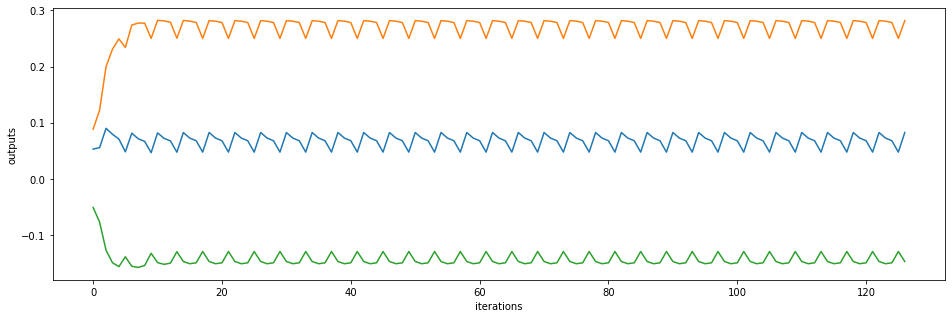

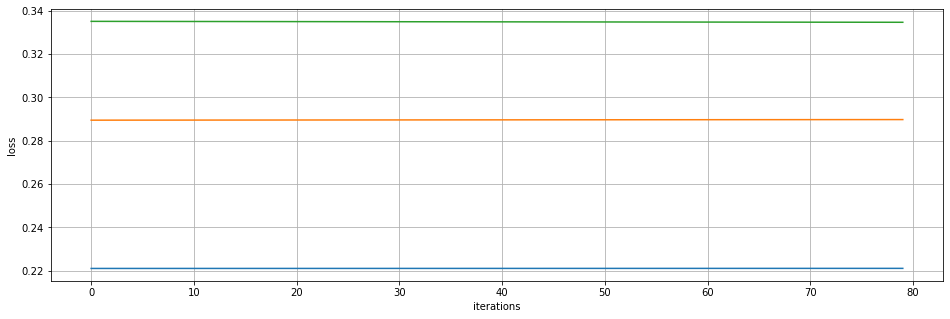

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 411
---------------
epoch 412
---------------
epoch 413
---------------
epoch 414
---------------
epoch 415
---------------
epoch 416
---------------
epoch 417
---------------
epoch 418
---------------
epoch 419
---------------
epoch 420
---------------
epoch 420
learning rate: 0.009001113096266168
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22102714]
 [0.28982804]
 [0.33471184]]


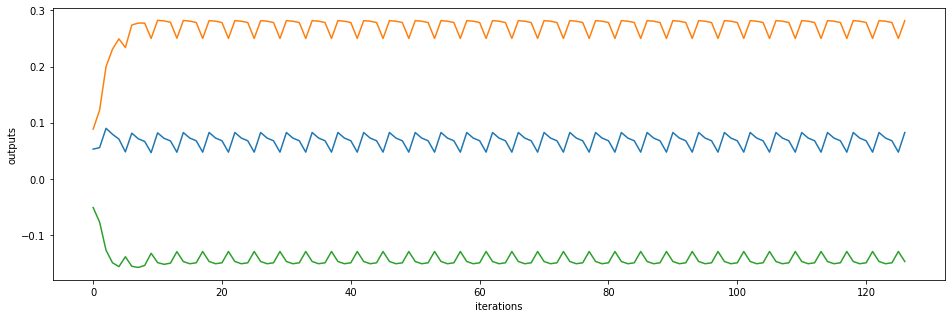

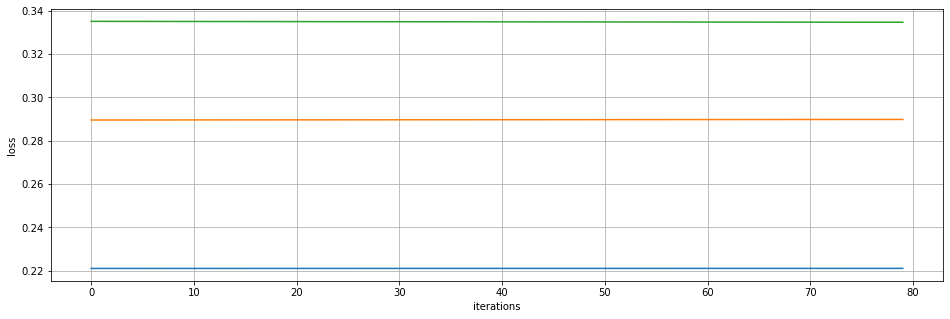

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 421
---------------
epoch 422
---------------
epoch 423
---------------
epoch 424
---------------
epoch 425
---------------
epoch 426
---------------
epoch 427
---------------
epoch 428
---------------
epoch 429
---------------
epoch 430
---------------
epoch 430
learning rate: 0.008978641223935558
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22103115]
 [0.28985772]
 [0.33466459]]


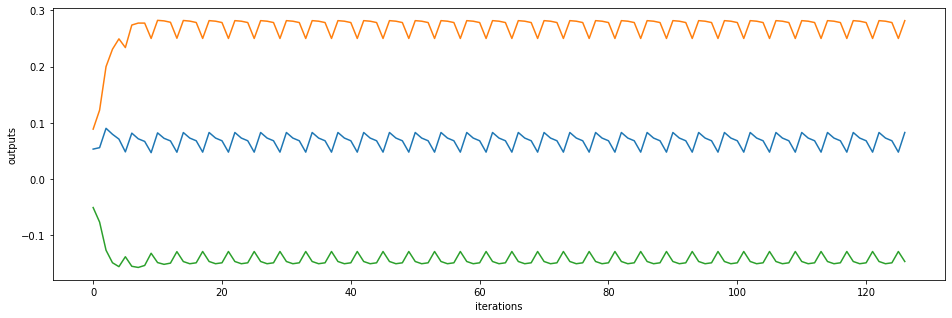

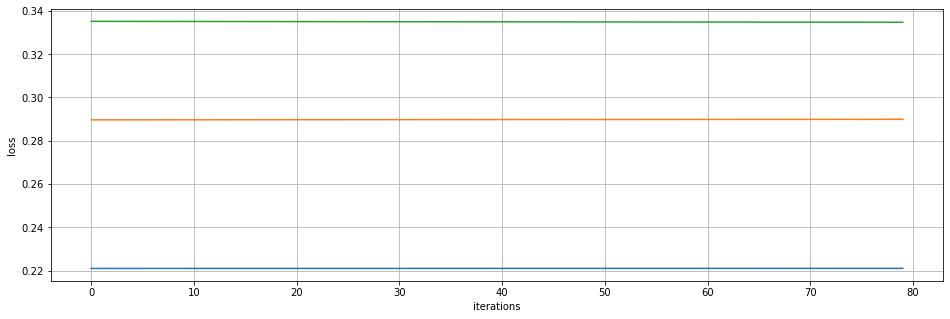

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 431
---------------
epoch 432
---------------
epoch 433
---------------
epoch 434
---------------
epoch 435
---------------
epoch 436
---------------
epoch 437
---------------
epoch 438
---------------
epoch 439
---------------
epoch 440
---------------
epoch 440
learning rate: 0.008956225454115896
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22103504]
 [0.28988659]
 [0.33461851]]


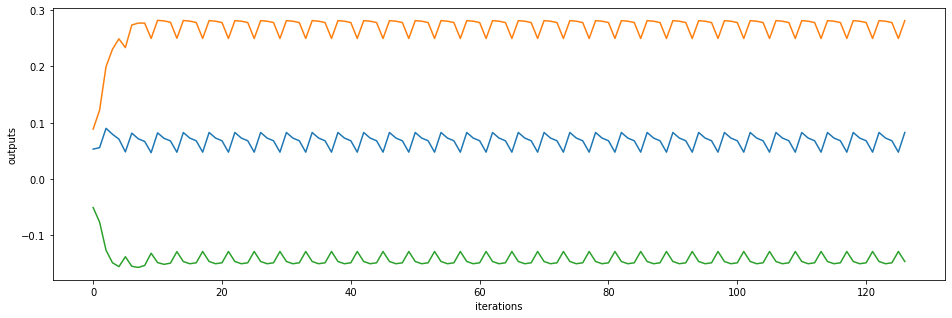

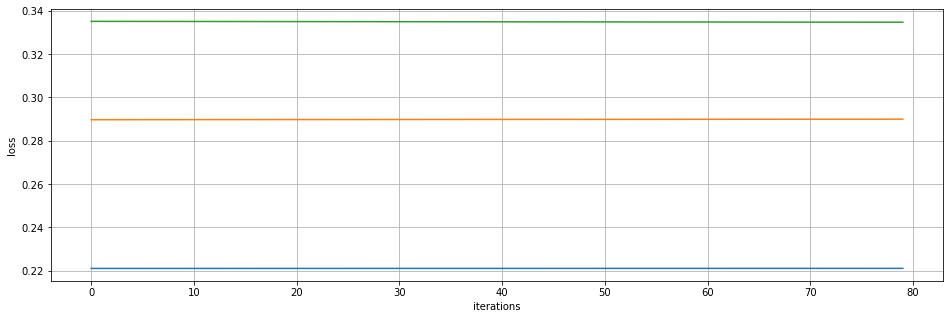

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 441
---------------
epoch 442
---------------
epoch 443
---------------
epoch 444
---------------
epoch 445
---------------
epoch 446
---------------
epoch 447
---------------
epoch 448
---------------
epoch 449
---------------
epoch 450
---------------
epoch 450
learning rate: 0.008933865646743571
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22103879]
 [0.28991465]
 [0.33457354]]


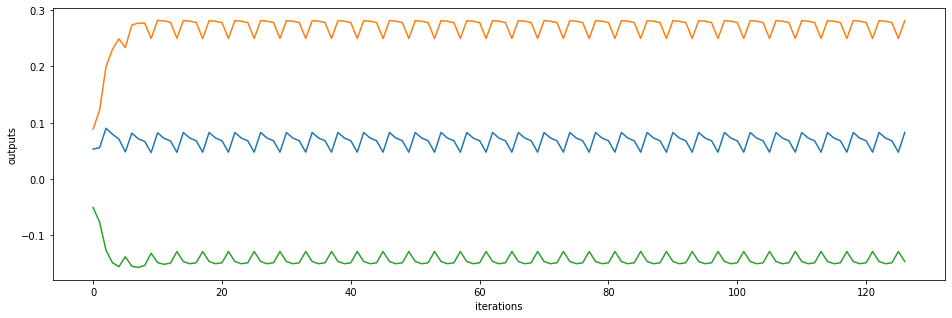

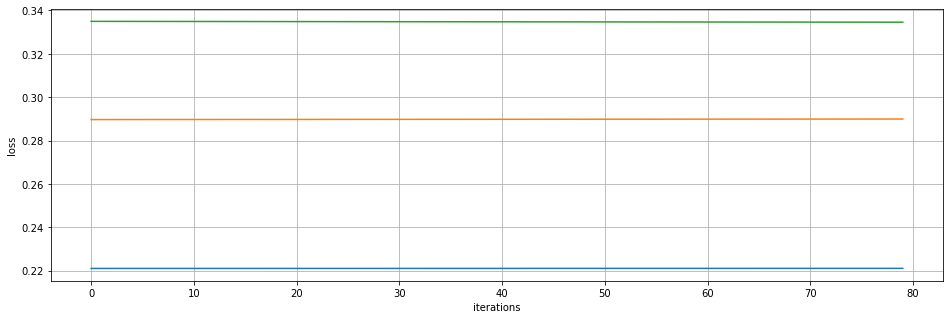

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 451
---------------
epoch 452
---------------
epoch 453
---------------
epoch 454
---------------
epoch 455
---------------
epoch 456
---------------
epoch 457
---------------
epoch 458
---------------
epoch 459
---------------
epoch 460
---------------
epoch 460
learning rate: 0.008911561662104639
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22104241]
 [0.28994195]
 [0.33452968]]


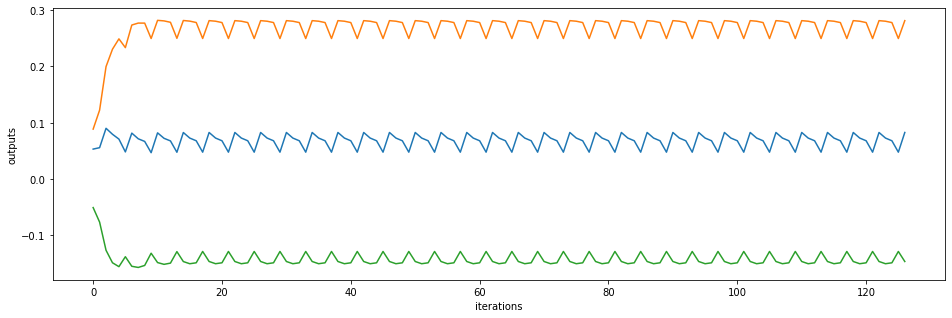

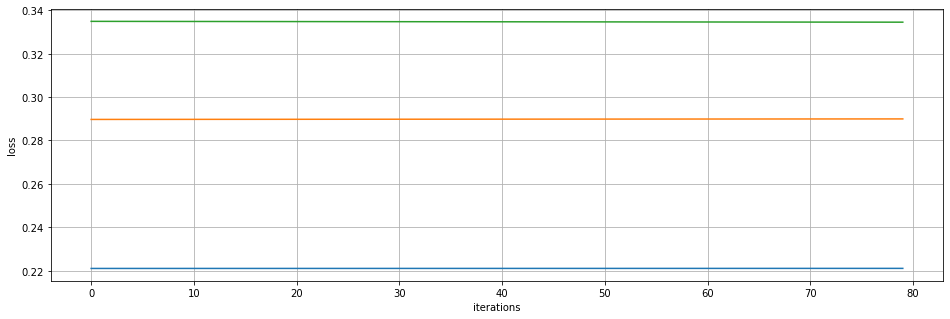

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 461
---------------
epoch 462
---------------
epoch 463
---------------
epoch 464
---------------
epoch 465
---------------
epoch 466
---------------
epoch 467
---------------
epoch 468
---------------
epoch 469
---------------
epoch 470
---------------
epoch 470
learning rate: 0.008889313360833965
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22104591]
 [0.28996849]
 [0.33448687]]


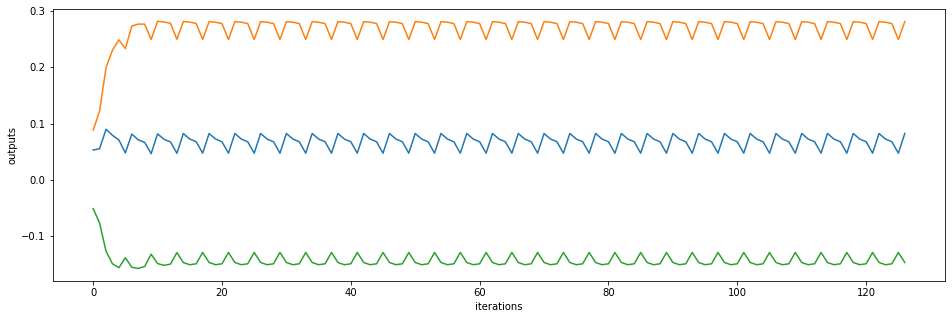

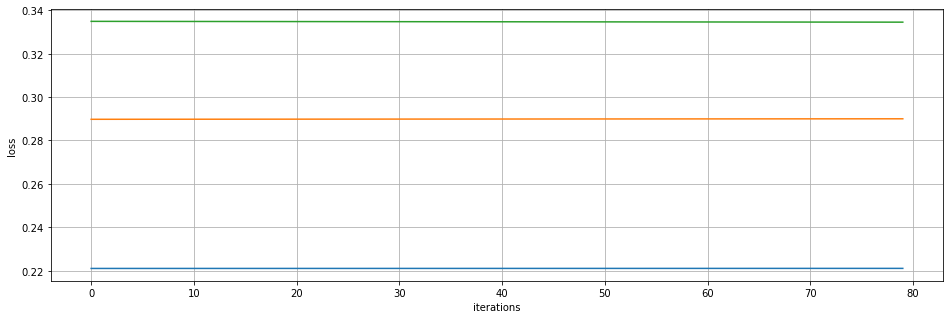

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 471
---------------
epoch 472
---------------
epoch 473
---------------
epoch 474
---------------
epoch 475
---------------
epoch 476
---------------
epoch 477
---------------
epoch 478
---------------
epoch 479
---------------
epoch 480
---------------
epoch 480
learning rate: 0.008867120603914345
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22104929]
 [0.2899943 ]
 [0.33444509]]


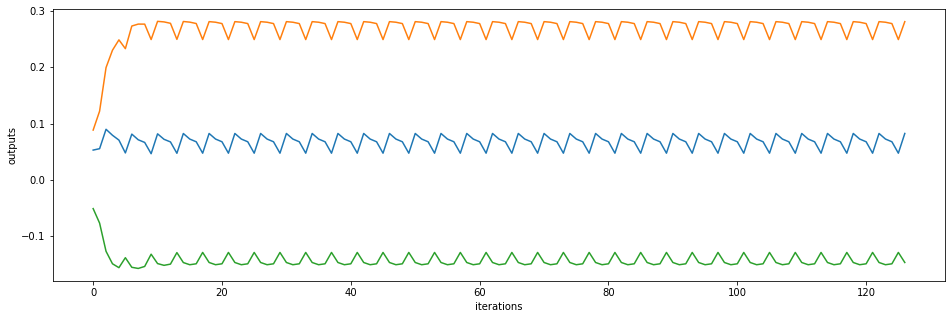

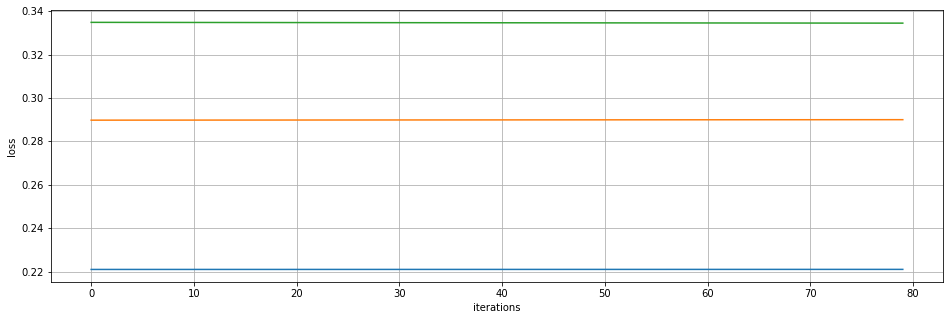

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 481
---------------
epoch 482
---------------
epoch 483
---------------
epoch 484
---------------
epoch 485
---------------
epoch 486
---------------
epoch 487
---------------
epoch 488
---------------
epoch 489
---------------
epoch 490
---------------
epoch 490
learning rate: 0.008844983252675648
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22105255]
 [0.2900194 ]
 [0.33440431]]


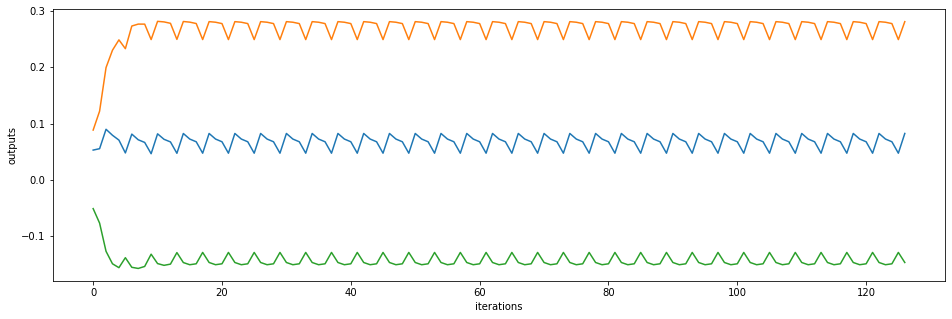

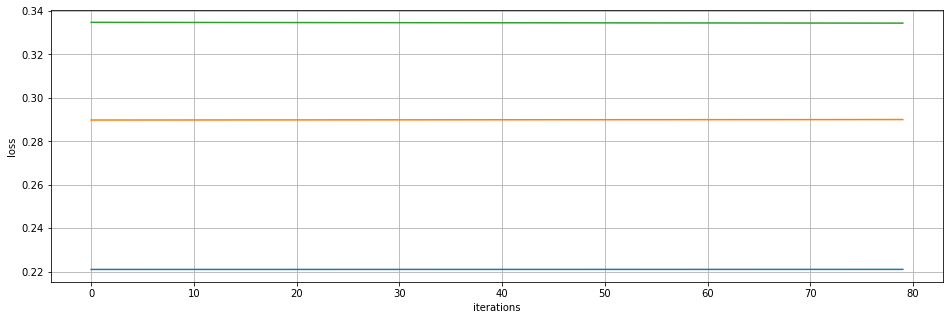

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 491
---------------
epoch 492
---------------
epoch 493
---------------
epoch 494
---------------
epoch 495
---------------
epoch 496
---------------
epoch 497
---------------
epoch 498
---------------
epoch 499
---------------
epoch 500
---------------
epoch 500
learning rate: 0.00882290116879394
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22105569]
 [0.29004381]
 [0.3343645 ]]


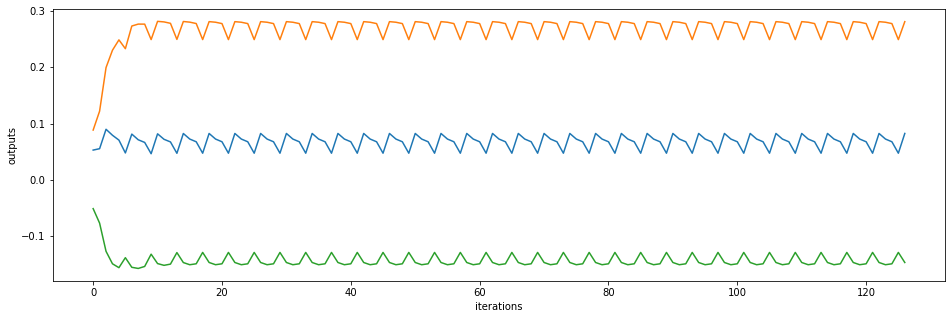

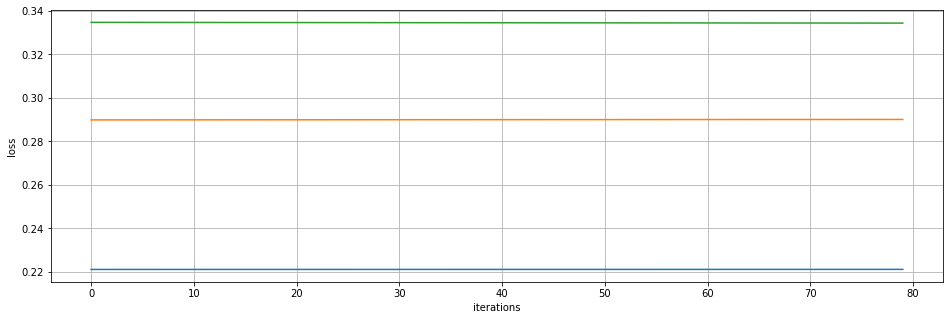

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 501
---------------
epoch 502
---------------
epoch 503
---------------
epoch 504
---------------
epoch 505
---------------
epoch 506
---------------
epoch 507
---------------
epoch 508
---------------
epoch 509
---------------
epoch 510
---------------
epoch 510
learning rate: 0.008800874214290617
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22105873]
 [0.29006755]
 [0.33432564]]


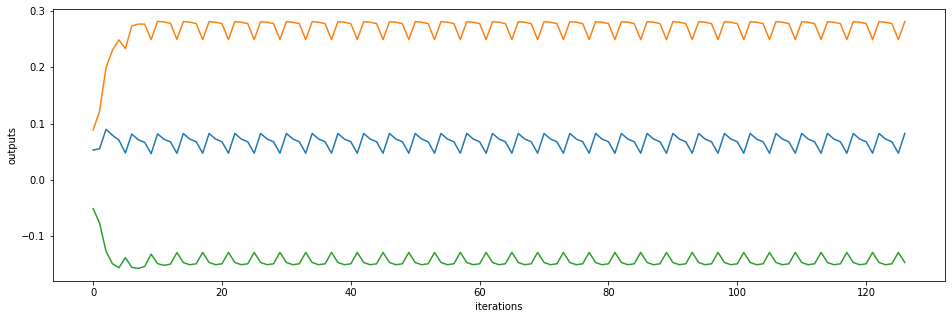

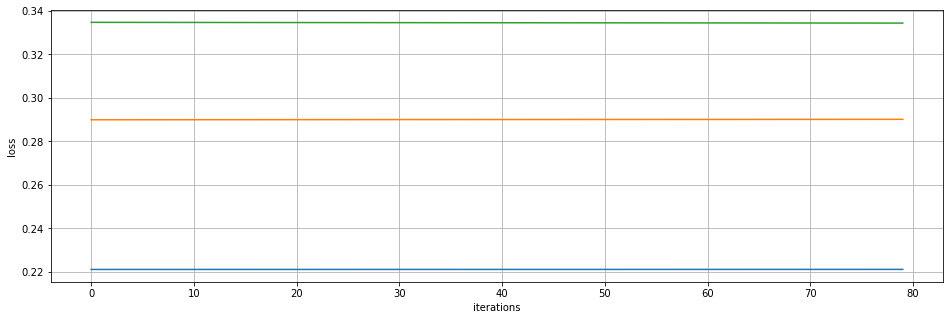

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 511
---------------
epoch 512
---------------
epoch 513
---------------
epoch 514
---------------
epoch 515
---------------
epoch 516
---------------
epoch 517
---------------
epoch 518
---------------
epoch 519
---------------
epoch 520
---------------
epoch 520
learning rate: 0.008778902251531552
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22106165]
 [0.29009064]
 [0.33428769]]


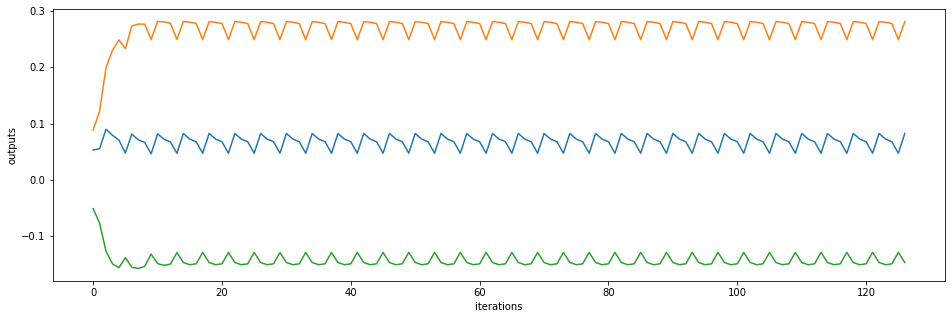

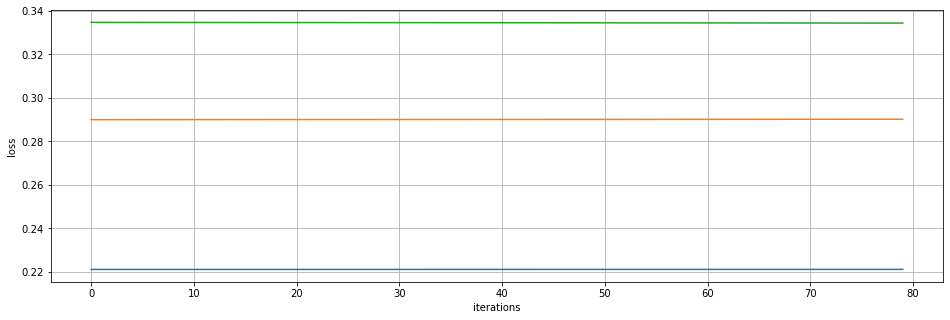

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 521
---------------
epoch 522
---------------
epoch 523
---------------
epoch 524
---------------
epoch 525
---------------
epoch 526
---------------
epoch 527
---------------
epoch 528
---------------
epoch 529
---------------
epoch 530
---------------
epoch 530
learning rate: 0.008756985143226233
sample 0
output: 
[[ 0.05288843]
 [ 0.08846774]
 [-0.05118426]]
target: 
[[1], [0], [0]]
-----------------average loss: [[0.22106447]
 [0.29011309]
 [0.33425063]]


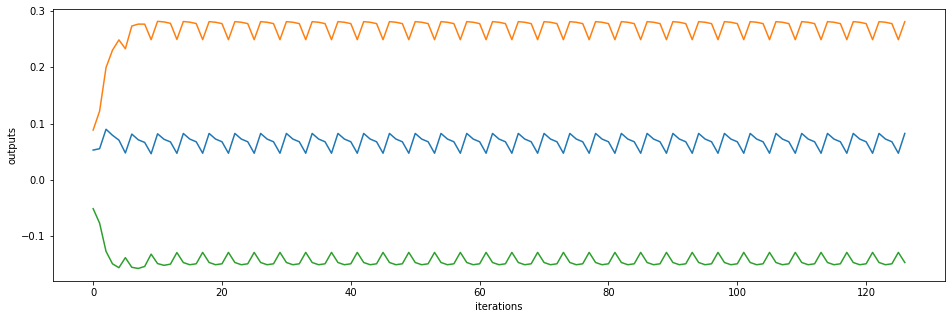

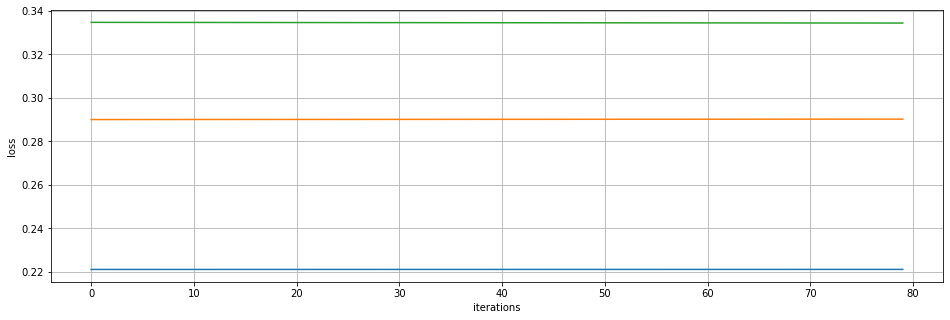

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 531
---------------
epoch 532
---------------
epoch 533
---------------
epoch 534


In [ ]:
epochs = 14000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    print("---------------")
    print("epoch " + str(e))
    network.learning_rate /= 1.00025
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 3)
  
        if e%10 == 0 and i%131 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("learning rate: " + str(network.learning_rate))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%10 == 0:        
        print("-----------------average loss: " + str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.show()
        
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.grid()
        plt.show()
        network.predict(input_data)
        
        
    prevLoss = loss
    if e > 10:
        losses.append(loss/len(input_data))
    if e > 90:
        del losses[0]
    
    
print("------------training finished successfully!------------")
        

In [ ]:
print(str(network.layers[-1].weights_H))

In [ ]:
print(str(network.layers[-2].weights_X))

In [ ]:
print(str(network.layers[-2].H))